# **Transfer Learning from ImageNet**

# Initialization of project folders and data

In [ ]:
import copy
import cv2
import datetime
import glob
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import plotly.express as px
import random
import re
import seaborn as sns
import shutil
import subprocess
import tabulate
import tarfile
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import torchvision.utils as vutils
import urllib.request
import warnings
import zipfile
from collections import Counter
from copy import deepcopy
from glob import glob
from google.colab import drive
from google.colab.patches import cv2_imshow
!pip install pytorch-gradcam
from gradcam.utils import visualize_cam
from gradcam import GradCAM
from matplotlib.ticker import FuncFormatter, LogLocator, MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, average_precision_score,
                             classification_report, confusion_matrix)
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
from torchvision.models.resnet import ResNet18_Weights
from tqdm.auto import tqdm
from tabulate import tabulate
#%load_ext tensorboard
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
warnings.filterwarnings('ignore', category=UserWarning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 70.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5246 sha256=3ef9598f2efca5c488b29ff90ca8de96b41a665e87fd408177afea73530c23e2
  Stored in directory: /root/.cache/pip/wheels/6f/f1/8f/96c81d13f617841f23cae192a77fea3e9e988d058ba9414f2c
Successfully built pytorch-gradcam


In [ ]:
# Set the random seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): #GPU
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
set_seed(42)

# Set the project folder
mount_point = '/content/drive/'
data_folder = '/content/data'

if not os.path.exists(mount_point):
    drive.mount(mount_point)
else:
    print(f"Drive is already mounted at {mount_point}")

os.chdir(os.path.join(mount_point))

# Delete existing data folders
if os.path.exists(data_folder):
    shutil.rmtree(data_folder)

# Create the data folder if it doesn't exist
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# Create the 'project' folder on Google Drive if it doesn't exist
project_folder = os.path.join(mount_point, 'MyDrive/D7047E/PROJECT/')
if not os.path.exists(project_folder):
    os.makedirs(project_folder)
    print(f"\Project folder created at {project_folder}")

# Create the 'dataset' folder on Google Drive if it doesn't exist
dataset_folder = os.path.join(mount_point, project_folder, 'dataset/FUSAR/')
if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)
    print(f"\nDataset folder created at {dataset_folder}")

#Create the 'accuracy' folder in the project folder on Google Drive if it doesn't exist
accuracy_folder = os.path.join(mount_point, project_folder, 'accuracy')
if not os.path.exists(accuracy_folder):
    os.makedirs(accuracy_folder)
    print(f"\nAccuracy folder created at {accuracy_folder}")

# Create the 'softmax' folder in the project folder on Google Drive if it doesn't exist
softmax_folder = os.path.join(mount_point, project_folder, 'softmax')
if not os.path.exists(softmax_folder):
    os.makedirs(softmax_folder)
    print(f"\nSoftmax folder created at {softmax_folder}")

# Create the 'logs' folder in the project folder on Google Drive if it doesn't exist
logs_folder = os.path.join(mount_point, project_folder, 'logs')
if not os.path.exists(logs_folder):
    os.makedirs(logs_folder)
    print(f"\nLogs folder created at {logs_folder}")

# Create the 'checkpoints' folder in the project folder on Google Drive if it doesn't exist
checkpoint_folder = os.path.join(mount_point, project_folder, 'checkpoint')
if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder)
    print(f"\nCheckpoints folder created at {checkpoint_folder}")

os.chdir('/content/')

def count(folder):
    if not os.path.exists(folder):
        num_files = 0
    else:
        num_files = 0
        for root, dirs, files in os.walk(folder):
            num_files += len(files)
    return num_files

print(f'\nThere are {count(dataset_folder)} files in the source folder: {dataset_folder}')
print(f'\nThere are {count(data_folder)} files in the destination folder: {data_folder}\n\n')

#Iterate over all the zip files in the folder
for zip_file in os.listdir(dataset_folder):
    if zip_file.endswith('.zip'):
       
        # Get the name of the folder to be created
        file_name = os.path.splitext(zip_file)[0]
        
        # Create the folder in the data folder
        file_path = os.path.join(data_folder)
        os.makedirs(file_path, exist_ok=True)
        
        # Extract the contents of the zip file into the folder
        with zipfile.ZipFile(os.path.join(dataset_folder, zip_file), 'r') as zip_ref:
            with tqdm(total=len(zip_ref.infolist()), desc=f"Extracting {zip_file}", unit="file") as pbar:
                for member in zip_ref.infolist():
                    zip_ref.extract(member, file_path)
                    pbar.update(1)

print("\n\nFiles downloaded and extracted successfully\n")

Drive is already mounted at /content/drive/

There are 2 files in the source folder: /content/drive/MyDrive/D7047E/PROJECT/dataset/FUSAR/

There are 0 files in the destination folder: /content/data




Extracting FUSAR_Ship1.1.zip:   0%|          | 0/3353 [00:00<?, ?file/s]



Files downloaded and extracted successfully



In [ ]:
# Define dataset paths dictionary
dataset_paths_orig = {}

# Iterate over all subdirectories in dataset folder
for subdir in os.listdir(data_folder):
    subdir_path = os.path.join(data_folder, subdir)
    if os.path.isdir(subdir_path):
        # Add subdirectory to dataset paths dictionary with its name as key
        dataset_paths_orig[subdir] = subdir_path

def count_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
        for file in files:
            count += 1
    return count

table = []
for key, value in dataset_paths_orig.items():
    num_files = count_files(value)
    table.append([key, value, num_files])

print(tabulate(table, headers=["Class Name", "Folder Path", "Num Files"], tablefmt="simple"))

# Load dimensions from the CSV file
csv_file_path = os.path.join(data_folder, 'meta.csv')
dimensions_df = pd.read_csv(csv_file_path)

# Remove rows with NaN values in "length" or "width" columns
dimensions_df_clean = dimensions_df.dropna(subset=['length', 'width'])

# Create dictionary with integer values
dimensions_dict = dimensions_df_clean.set_index('id')[['length', 'width']].astype(int).T.to_dict('list')

Class Name      Folder Path                     Num Files
--------------  ----------------------------  -----------
Cargo           /content/data/Cargo                  2114
Tanker          /content/data/Tanker                  248
Fishing         /content/data/Fishing                 789
Tug             /content/data/Tug                      64
HighSpeedCraft  /content/data/HighSpeedCraft           15
Passenger       /content/data/Passenger                64


In [ ]:
print(dimensions_dict)

{'Ship_C01S01N0001': [138, 26], 'Ship_C01S01N0002': [87, 12], 'Ship_C01S02N0001': [229, 32], 'Ship_C01S02N0002': [180, 30], 'Ship_C01S02N0003': [150, 22], 'Ship_C01S02N0004': [149, 22], 'Ship_C01S02N0005': [135, 22], 'Ship_C01S02N0006': [122, 16], 'Ship_C01S02N0007': [199, 33], 'Ship_C01S02N0008': [225, 32], 'Ship_C01S02N0009': [175, 27], 'Ship_C01S02N0010': [190, 33], 'Ship_C01S02N0011': [149, 23], 'Ship_C01S02N0012': [199, 32], 'Ship_C01S02N0013': [180, 31], 'Ship_C01S02N0014': [189, 32], 'Ship_C01S02N0015': [147, 21], 'Ship_C01S02N0016': [136, 20], 'Ship_C01S02N0017': [190, 32], 'Ship_C01S02N0018': [163, 26], 'Ship_C01S02N0019': [140, 20], 'Ship_C01S02N0020': [99, 16], 'Ship_C01S02N0021': [289, 45], 'Ship_C01S02N0022': [135, 19], 'Ship_C01S02N0023': [140, 20], 'Ship_C01S02N0024': [189, 32], 'Ship_C01S02N0025': [157, 22], 'Ship_C01S02N0026': [147, 21], 'Ship_C01S02N0027': [133, 20], 'Ship_C01S02N0028': [179, 25], 'Ship_C01S02N0029': [150, 22], 'Ship_C01S02N0030': [159, 24], 'Ship_C01

In [ ]:
# Show rows with NaN values in either "length" or "width" columns
na_rows = dimensions_df[dimensions_df[['length', 'width']].isna().any(axis=1)]

# Extract 7th and 8th characters from filenames
pattern = r'\w{6}(\w{2})\w*'
filenames = na_rows['id'].tolist()
characters = set()
for filename in filenames:
    match = re.findall(pattern, filename)
    characters.update(match)

# Print the unique characters
print("Unique 7th and 8th characters from filenames with NA values:", characters)

Unique 7th and 8th characters from filenames with NA values: {'07'}


In [ ]:
# Count rows with NaN values in either "length" or "width" columns
na_count = dimensions_df[['length', 'width']].isna().any(axis=1).sum()

# Print the count
print("Number of rows with NaN values in 'length' or 'width' columns:", na_count)

Number of rows with NaN values in 'length' or 'width' columns: 1116


In [ ]:
#Function to include selected folders
def get_user_selected_folders(dataset_paths_orig):
    table = []
    for idx, (key, value) in enumerate(dataset_paths_orig.items()):
        num_files = count_files(value)
        table.append([idx, key, value, num_files])

    print("\nList of available folders:\n")
    print(tabulate(table, headers=["Num", "Class Name", "Folder Path", "Num Files"], tablefmt="simple"))

    user_input = input("\nEnter the folder numbers you want to include in the dataset (comma-separated, press Enter to select all): ")

    # If pressed Enter, select all folders
    if user_input == '':
        folder_indices = range(len(dataset_paths_orig))
    else:
        folder_indices = list(map(int, user_input.split(',')))

    selected_folders = {}
    for idx, key in enumerate(dataset_paths_orig.keys()):
        if idx in folder_indices:
            selected_folders[key] = dataset_paths_orig[key]

    return selected_folders

dataset_paths = get_user_selected_folders(dataset_paths_orig)

table = []
for idx, (key, value) in enumerate(dataset_paths.items()):
    num_files = count_files(value)
    table.append([idx, key, value, num_files])

print("\nSelected folders and their details:\n")
print(tabulate(table, headers=["Num", "Class Name", "Folder Path", "Num Files"], tablefmt="simple"))


List of available folders:

  Num  Class Name      Folder Path                     Num Files
-----  --------------  ----------------------------  -----------
    0  Cargo           /content/data/Cargo                  2114
    1  Tanker          /content/data/Tanker                  248
    2  Fishing         /content/data/Fishing                 789
    3  Tug             /content/data/Tug                      64
    4  HighSpeedCraft  /content/data/HighSpeedCraft           15
    5  Passenger       /content/data/Passenger                64

Enter the folder numbers you want to include in the dataset (comma-separated, press Enter to select all): 

Selected folders and their details:

  Num  Class Name      Folder Path                     Num Files
-----  --------------  ----------------------------  -----------
    0  Cargo           /content/data/Cargo                  2114
    1  Tanker          /content/data/Tanker                  248
    2  Fishing         /content/data/Fishing 

In [ ]:
# Checking for available image sizes
unique_sizes = {}

for i, class_name in enumerate(dataset_paths):
    class_image_count = 0
    for root, dirs, files in os.walk(dataset_paths[class_name]):
        for file in files:
            if file.endswith(('.png', '.jpg', '.tiff')):
                file_path = os.path.join(root, file)
                class_image_count += 1

                # Open the image and update the count for its size
                with Image.open(file_path) as img:
                    width, height = img.size
                    size = (width, height)
                    if size in unique_sizes:
                        unique_sizes[size] += 1
                    else:
                        unique_sizes[size] = 1

print("Unique image sizes:\n")
table = [(k[0], k[1], v) for k, v in unique_sizes.items()]
headers = ["Weight", "Height", "Count"]
print(tabulate(table, headers=headers, tablefmt="simple"))

Unique image sizes:

  Weight    Height    Count
--------  --------  -------
     512       512     3291
     512       488        1
     448       512        2


In [ ]:
# class ShipDataset(Dataset):
#     def __init__(self, data_folder, dimensions_dict, label_mapping, transform=None):
#         self.data_paths = [path for path in data_folder if os.path.splitext(os.path.basename(path))[0] in dimensions_dict]
#         self.data_paths = [path for path in self.data_paths if dimensions_dict[os.path.splitext(os.path.basename(path))[0]] != [0, 0]]
#         self.dimensions_dict = dimensions_dict
#         self.label_mapping = label_mapping
#         self.transform = transform

#     def __len__(self):
#         return len(self.data_paths)

#     def __getitem__(self, idx):
#         image_path = self.data_paths[idx]
#         img = Image.open(image_path)
#         if self.transform:
#             img = self.transform(img)
#         original_label = int(image_path.split("/")[-1][6:8])
#         label = self.label_mapping[original_label]  # label mapping
#         ship_id = image_path.split("/")[-1][:-4].rstrip(".")
#         dimensions = self.dimensions_dict.get(ship_id)
#         if dimensions is None:
#             print(f"Warning: Could not find dimensions for ship ID: {ship_id}. It will not be included in a dataset.")
#             dimensions = [0, 0]
#         length, width = dimensions
#         return img, label, length, width

from sklearn.preprocessing import MinMaxScaler

class ShipDataset(Dataset): # with MinMaxScaler dimensionality normalization with feature_range=(0, 3)
    def __init__(self, data_folder, dimensions_dict, label_mapping, transform=None):
        self.data_paths = [path for path in data_folder if os.path.splitext(os.path.basename(path))[0] in dimensions_dict]
        #self.data_paths = [path for path in self.data_paths if dimensions_dict[os.path.splitext(os.path.basename(path))[0]] != [0, 0]]
        self.data_paths = [path for path in self.data_paths if all(dim != 0 for dim in dimensions_dict[os.path.splitext(os.path.basename(path))[0]])]
        self.dimensions_dict = dimensions_dict
        self.label_mapping = label_mapping
        self.transform = transform

        # Filter out images with length > 470 and width > 50
        self.data_paths = [path for path in self.data_paths if dimensions_dict[os.path.splitext(os.path.basename(path))[0]][0] <= 470 and dimensions_dict[os.path.splitext(os.path.basename(path))[0]][1] <= 50]

        # Get all lengths and widths
        all_lengths = [dimensions[0] for dimensions in dimensions_dict.values() if dimensions[0] <= 470]
        all_widths = [dimensions[1] for dimensions in dimensions_dict.values() if dimensions[1] <= 50]

        # Initialize and fit scalers
        self.length_scaler = MinMaxScaler(feature_range=(0, 3)).fit(np.array(all_lengths).reshape(-1, 1))
        self.width_scaler = MinMaxScaler(feature_range=(0, 3)).fit(np.array(all_widths).reshape(-1, 1))

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        image_path = self.data_paths[idx]
        img = Image.open(image_path)
        if self.transform:
            img = self.transform(img)
        original_label = int(image_path.split("/")[-1][6:8])
        label = self.label_mapping[original_label]  # label mapping
        ship_id = image_path.split("/")[-1][:-4].rstrip(".")
        dimensions = self.dimensions_dict.get(ship_id)
        if dimensions is None:
            print(f"Warning: Could not find dimensions for ship ID: {ship_id}. It will not be included in a dataset.")
            dimensions = [0, 0]
        length, width = dimensions

        # Normalize length and width
        length = self.length_scaler.transform(np.array([[length]]))[0][0]
        width = self.width_scaler.transform(np.array([[width]]))[0][0]

        # Convert length and width to PyTorch tensors of type float
        length = torch.tensor([length], dtype=torch.float32)
        width = torch.tensor([width], dtype=torch.float32)

        return img, label, length, width


# Load data and create stratified train, val, and test sets
data = []
labels = []
unique_sizes = {}
label_to_class_name = {}

for class_name in dataset_paths:
    for root, dirs, files in os.walk(dataset_paths[class_name]):
        for file in files:
            if file.endswith(('.png', '.jpg', '.tiff')):
                file_path = os.path.join(root, file)
                with Image.open(file_path) as img:
                    img_width, img_height = img.size
                    if (img_width, img_height) == (512, 512) or (img_width, img_height) == (256, 256):
                        data.append(file_path)
                        label = int(file[6:8])  # Extract label index from the file name
                        labels.append(label)

                        # Update the label_to_class_name dictionary
                        if label not in label_to_class_name:
                            label_to_class_name[label] = class_name
                        
                        # Open the image and update the count for its size
                        with Image.open(file_path) as img:
                            width, height = img.size
                            size = (width, height)
                            if size in unique_sizes:
                                unique_sizes[size] += 1
                            else:
                                unique_sizes[size] = 1

# Count the number of samples per class
label_counts = Counter(labels)

# Extract unique labels
unique_labels = sorted(set(labels))

# Map the original labels to new labels
label_map = {label: i for i, label in enumerate(sorted(unique_labels))}

# Create new labels
new_labels = [label_map[label] for label in labels]

# Create a list of actual class names based on the label_map
actual_class_names = [label_to_class_name[label] for label in sorted(label_map.keys())]

# Calculate the total number of samples
total_samples = len(new_labels)

# Normalize the counts
label_weights = {label: count / total_samples for label, count in Counter(new_labels).items()}

# Invert the normalized counts to get the class weights
class_weights = {label: 1 / weight for label, weight in label_weights.items()}

# Convert the class weights to a tensor
class_weights_tensor = torch.tensor([class_weights[label_map[label]] for label in sorted(set(labels))])

# Split the data into train, validation, and test datasets
train_data, test_data, train_labels, test_labels = train_test_split(data, new_labels, test_size=0.2, random_state=42, stratify=new_labels)  # 20% images for test
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=42, stratify=train_labels)  # 20% images for validation (25% of the remaining 80%)


print("Unique image sizes:\n")
table = [(k[0], k[1], v) for k, v in unique_sizes.items()]
headers = ["Weight", "Height", "Count"]
print(tabulate(table, headers=headers, tablefmt="simple"))

total_images = len(data)
print(f"\n\nTotal number of images: {total_images}\n")

# Print the sizes of the datasets
table = [["Train set", len(train_data)], ["Validation set", len(val_data)], ["Test set", len(test_data)]]
print(tabulate(table, headers=["Dataset", "Size"], tablefmt="simple"))

# Verify the splits are disjoint
def verify_dj(train_data, val_data, test_data):
    all_data = np.concatenate((train_data, val_data, test_data))
    unique_data = set(all_data)

    if len(unique_data) == len(all_data):
        print("\n\nThe splits are disjoint\n")
    else:
        print("\n\nThere are common elements between the splits\n")

# Call the function to verify the splits
verify_dj(train_data, val_data, test_data)

# Initialize number of channels for computing the average mean and standard deviation
channels = 1  # Set to 1 for grayscale images, and 3 for color images

# Initialize variables for computing the average mean and standard deviation
n_images_all = 0
mean = np.zeros(channels)
std = np.zeros(channels)

# Iterate over the train set to compute the normalization parameters
for image_path in tqdm(train_data, desc="Computing normalization parameters", unit="image"):
    with Image.open(image_path) as image:
        n_images_all += 1
        if channels == 1:
            image = image.convert('L')  # Convert to grayscale
        image = np.asarray(image) / 255.0  # Convert to numpy array and scale to [0, 1]
        mean += np.mean(image, axis=(0, 1))
        std += np.std(image, axis=(0, 1))

# Compute the average mean and standard deviation for all the images in the train set
mean /= n_images_all
std /= n_images_all

mean = np.round(mean, 3)
std = np.round(std, 3)

print(f"\nMean: {mean}, Standard Deviation: {std}\n\n")

transform_size = 512

# Data transforms
transform = {
    'train': transforms.Compose([
        transforms.Resize(transform_size),
        transforms.RandomHorizontalFlip(),
        #transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(transform_size),
        #transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(transform_size),
        #transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'visualization': transforms.Compose([
        transforms.Resize(transform_size),
        #transforms.CenterCrop(256),
        transforms.ToTensor(),
    ])
}

# Create datasets for train, val, and test
train_dataset = ShipDataset(train_data, dimensions_dict, label_map, transform=transform['train'])
val_dataset = ShipDataset(val_data, dimensions_dict, label_map, transform=transform['val'])
test_dataset = ShipDataset(test_data, dimensions_dict, label_map, transform=transform['test'])
num_classes = len(actual_class_names)

batch_size = 64
num_workers = 0

# Create dataloaders for train, val, and test sets
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'valid': DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
}

# Print dataloaders
table = []
for key, dataloader in dataloaders.items():
    num_batches = len(dataloader)
    num_images = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    shuffle_status = "Yes" if key != 'test' else "No"

    table.append([key.capitalize(), num_batches, num_images, batch_size, shuffle_status])

# Print DataLoader properties as a table
headers = ["DataLoader", "Batches", "Images", "Batch Size", "Shuffle"]
print(tabulate(table, headers=headers, tablefmt="simple"))

# Print the unique labels
unique_labels = sorted(set(labels))
print("\n\nUnique labels:", unique_labels)

# Initialize pickle files for metrics saving  
pickle_files = [
    "all_train_accuracies.pickle",
    "all_train_losses.pickle",
    "all_val_accuracies.pickle",
    "all_val_losses.pickle",
    "all_learning_rates.pickle",
]

Unique image sizes:

  Weight    Height    Count
--------  --------  -------
     512       512     3291


Total number of images: 3291

Dataset           Size
--------------  ------
Train set         1974
Validation set     658
Test set           659


The splits are disjoint



Computing normalization parameters:   0%|          | 0/1974 [00:00<?, ?image/s]


Mean: [0.044], Standard Deviation: [0.062]


DataLoader      Batches    Images    Batch Size  Shuffle
------------  ---------  --------  ------------  ---------
Train                28      1785            64  Yes
Valid                10       597            64  Yes
Test                 10       603            64  No


Unique labels: [1, 4, 5, 8, 12, 13]


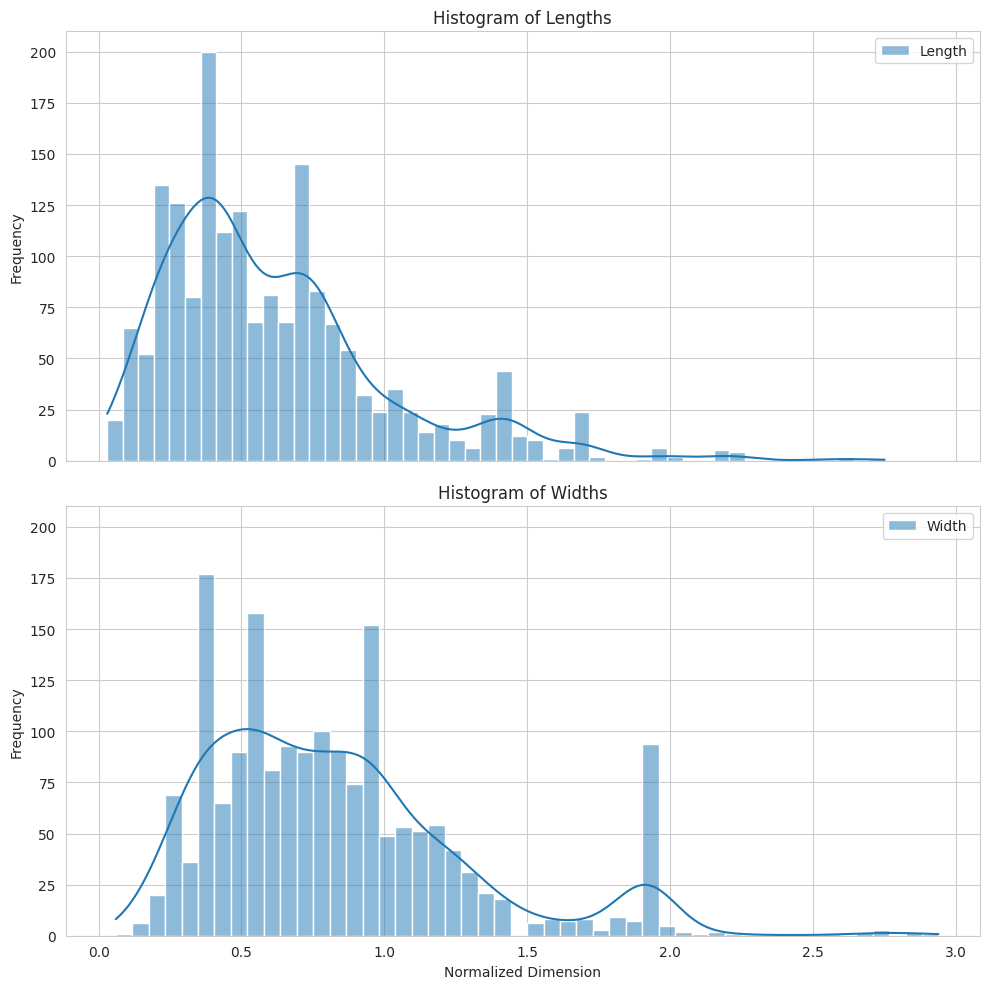

In [ ]:
for i in range(len(train_dataset)):
    img, label, length, width = train_dataset[i]
    if length == 0 or width == 0:
        print(f"Index: {i}, Label: {label}, Length: {length}, Width: {width}")


# Initialize lists to store lengths and widths
lengths = []
widths = []

# Iterate over the dataset and collect all lengths and widths
for i in range(len(train_dataset)):
    img, label, length, width = train_dataset[i]
    if length != 0 or width != 0:
        lengths.append(length)
        widths.append(width)

lengths_np = np.array([tensor.numpy() for tensor in lengths])
widths_np = np.array([tensor.numpy() for tensor in widths])

# Set seaborn style for better look
sns.set_style("whitegrid")

# Initialize the figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(10,10), sharex=True, sharey=True)

# Create the histogram for lengths
sns.histplot(lengths_np, bins=50, color='g', label='Length', kde=True, ax=axes[0])
axes[0].set_xlabel('')  # Remove x label for the first subplot
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].set_title('Histogram of Lengths')

# Create the histogram for widths
sns.histplot(widths_np, bins=50, color='b', label='Width', kde=True, ax=axes[1])
axes[1].set_xlabel('Normalized Dimension')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].set_title('Histogram of Widths')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
print(lengths)
print(widths)


[tensor([1.1805]), tensor([0.3459]), tensor([0.2632]), tensor([0.2030]), tensor([0.7368]), tensor([0.1128]), tensor([0.7444]), tensor([0.2256]), tensor([0.3985]), tensor([0.4737]), tensor([0.6692]), tensor([0.4060]), tensor([0.3985]), tensor([0.5188]), tensor([1.0451]), tensor([0.6992]), tensor([0.0677]), tensor([0.6090]), tensor([0.7293]), tensor([0.5038]), tensor([0.8271]), tensor([0.3985]), tensor([0.8872]), tensor([0.3759]), tensor([0.2707]), tensor([0.2857]), tensor([0.3985]), tensor([0.2030]), tensor([0.3759]), tensor([0.7444]), tensor([0.5564]), tensor([0.4361]), tensor([0.5414]), tensor([0.6917]), tensor([0.7068]), tensor([0.6165]), tensor([1.0376]), tensor([0.7218]), tensor([0.5865]), tensor([0.9624]), tensor([0.4361]), tensor([0.3985]), tensor([0.8571]), tensor([0.4211]), tensor([0.3534]), tensor([1.4511]), tensor([0.4962]), tensor([0.3008]), tensor([0.4887]), tensor([0.4737]), tensor([0.2857]), tensor([0.3985]), tensor([0.7519]), tensor([0.3985]), tensor([1.0226]), tensor([0

# Imaging etc.


In [ ]:
class SAR_CNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SAR_CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

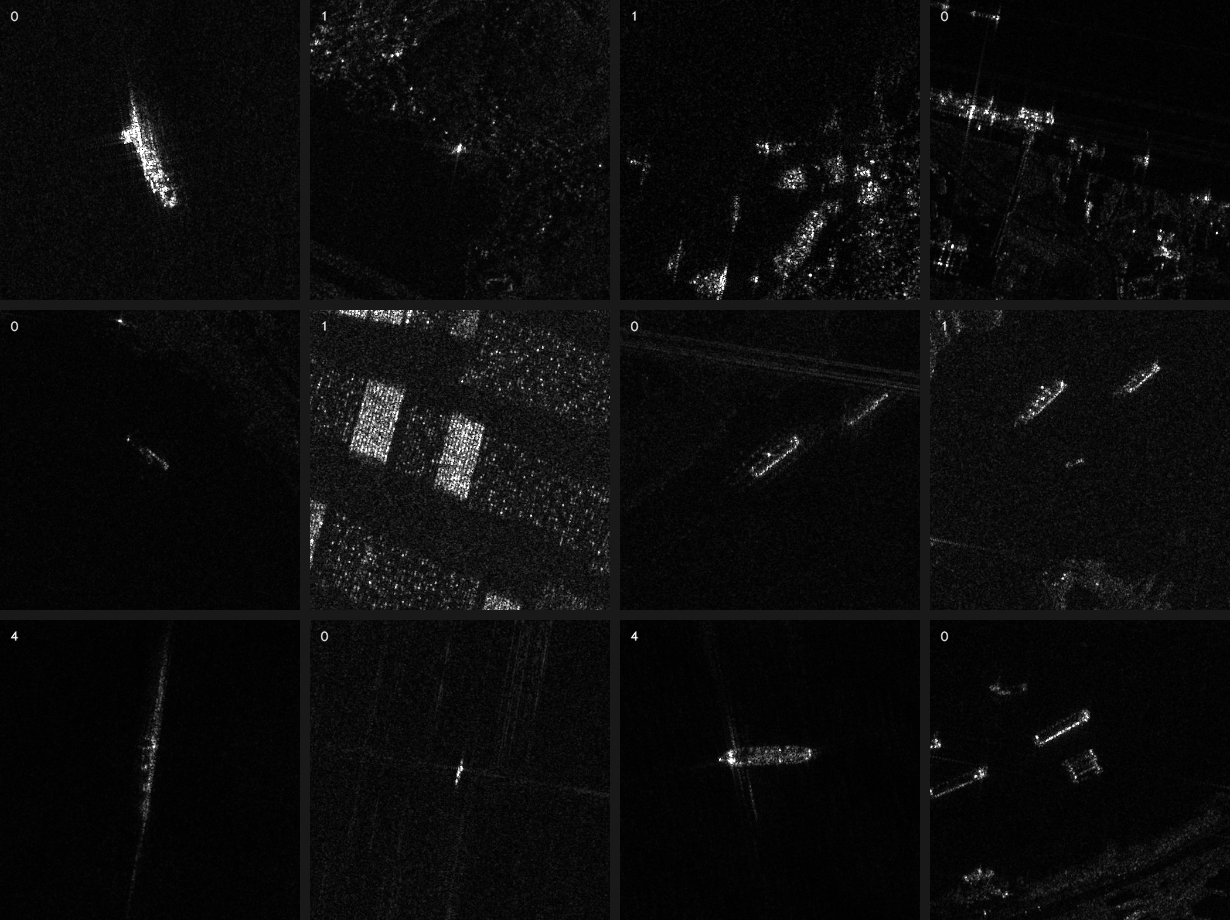

In [ ]:
# Define the number of rows and columns for the grid
num_images = 12
num_cols = 4
num_rows = 3

# Define the size of the grid cells and padding
cell_width = 300
cell_height = 300
padding = 10  # Change this value to adjust the space between images

# Set the background color
bg_color = (25, 25, 25)  # Light gray (B, G, R)

# Create a blank image to hold the grid
grid_height = num_rows * (cell_height + padding) - padding
grid_width = num_cols * (cell_width + padding) - padding
grid = np.full((grid_height, grid_width, 3), bg_color, dtype=np.uint8)

# Shuffle the train dataset
#random.shuffle(train_data)

# Shuffle the train dataset and labels together
# train_data_labels = list(zip(train_data, train_labels))
# random.shuffle(train_data_labels)
# train_data, train_labels = zip(*train_data_labels)

# Loop over the images and add them to the grid
for i, image_path in enumerate(train_data[:num_images]):
    
    # Load the image
    image = cv2.imread(image_path)
    
    # Resize the image to fit in the grid cell
    image = cv2.resize(image, (cell_width, cell_height))
    
    # Compute the row and column of the current cell
    row = i // num_cols
    col = i % num_cols
    
    # Compute the top-left corner of the current cell
    x = col * (cell_width + padding)
    y = row * (cell_height + padding)
    
    # Insert the image into the grid
    grid[y:y+cell_height, x:x+cell_width] = image

    # Get the corresponding label
    label = train_labels[i]

    # Set the text properties
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.4
    font_color = (255, 255, 255)  # Green
    font_thickness = 1

    # Add the label at the left upper corner of the image
    cv2.putText(grid, str(label), (x + 10, y + 20), font, font_scale, font_color, font_thickness, cv2.LINE_AA)

# Display the grid
cv2_imshow(grid)

# Wait for a key press
cv2.waitKey(0)

# Close all windows
cv2.destroyAllWindows()

ValueError: ignored

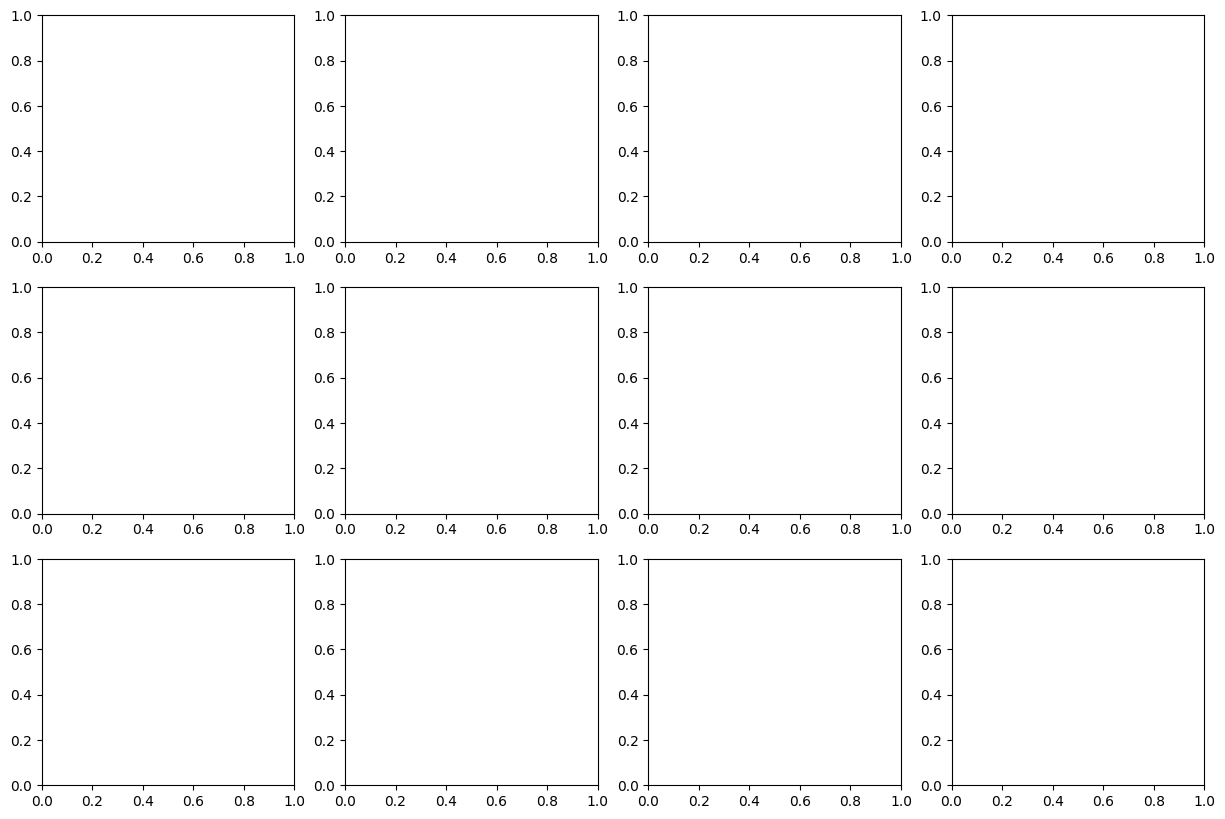

In [ ]:
# Define the number of rows and columns for the grid
num_images = 12
num_cols = 4
num_rows = 3

# Shuffle the train dataset
random_indices = random.sample(range(len(train_dataset)), num_images)

# Loop over the images and add them to the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for i, idx in enumerate(random_indices):
    
    # Load the image, label, and file path using the dataset's __getitem__() method
    image_tensor, int_label, file_list = train_dataset[idx]

    # Convert the image tensor to a NumPy array and transpose the dimensions to match the format expected by matplotlib
    image = image_tensor.squeeze().numpy()
    
    # Get the corresponding text label
    text_label = train_labels[idx]

    # Display the image
    ax = axes.flatten()[i]
    ax.imshow(image, cmap="gray")
    ax.set_title(f"{text_label}\n{file_list}")
    ax.axis("off")

# Adjust the layout and display the grid
plt.tight_layout()
plt.show()

ValueError: ignored

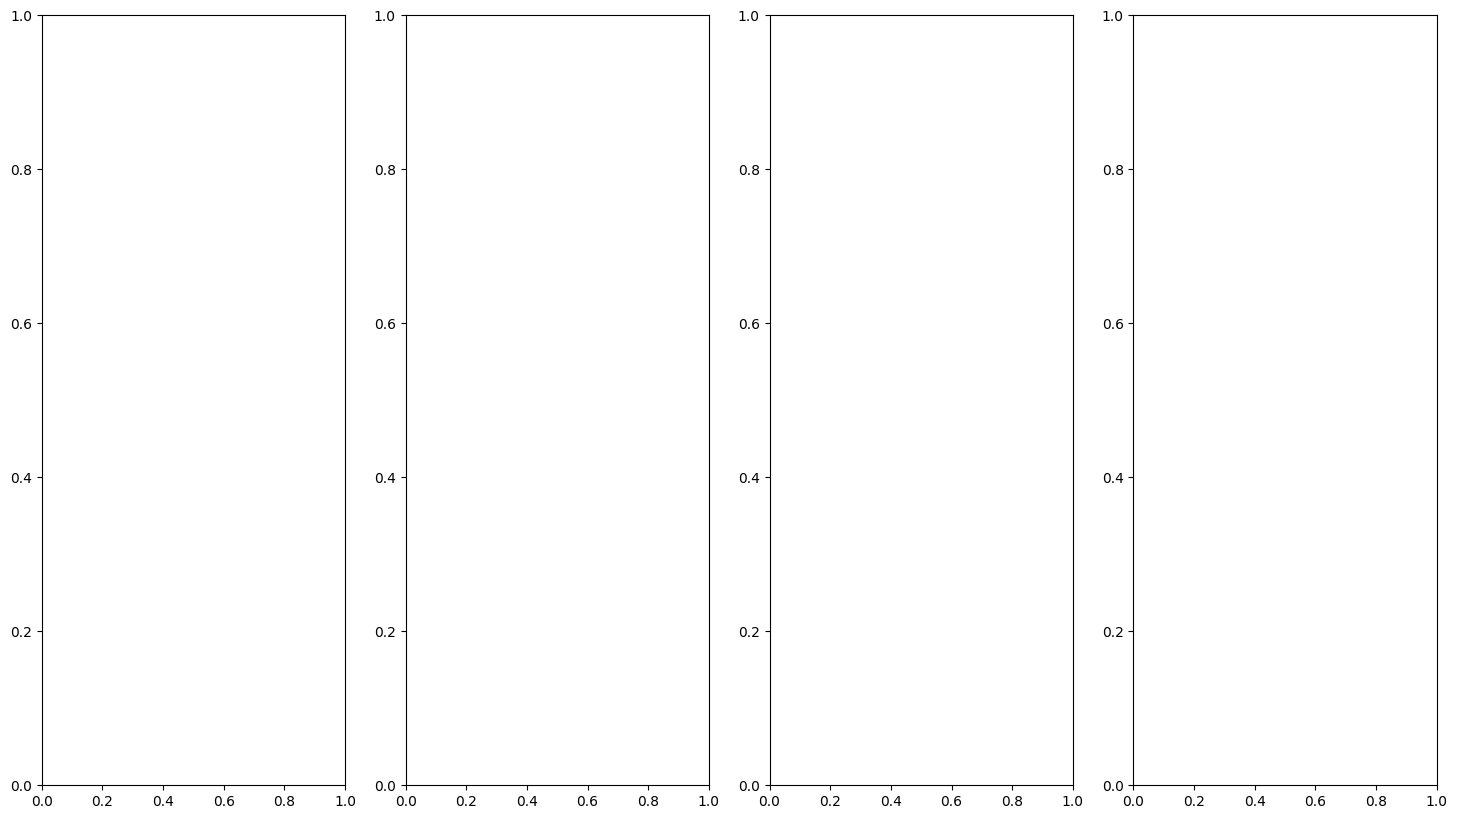

In [ ]:
num_images_to_show = 4

# Choose random indices from the training dataset
random_indices = [random.randint(0, len(train_dataset) - 1) for _ in range(num_images_to_show)]

# Load and visualize the images
fig, axs = plt.subplots(1, num_images_to_show, figsize=(18, 10))

for i, idx in enumerate(random_indices):
    # Load the image and label using the dataset's __getitem__() method
    image, label, file_path = train_dataset[idx]

    # Convert the image back to a PIL Image for visualization
    pil_image = transforms.ToPILImage()(image)

    # Show the image and its label on the corresponding axis
    axs[i].imshow(pil_image, cmap='binary')
    axs[i].set_title(f"{label}\n{file_path} ")
    axs[i].axis("off")

plt.show()

# ResNet18 model and functions

In [ ]:
def convert_to_cpu(tensor_list):
    return [tensor.cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in tensor_list]


def save_dicts_to_files(file_prefix, data_dicts, accuracy_folder):
    for data_dict, file in zip(data_dicts, pickle_files):
        file_name = os.path.join(accuracy_folder, f"{file[:-7]}{file_prefix}.pickle")
        with open(file_name, "wb") as handle:
            converted_dict = {k: [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in v] for k, v in data_dict.items()}
            pickle.dump(converted_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


def load_dicts_from_files(pickle_files, accuracy_folder):
    loaded_dicts = []
    for file in pickle_files:
        file_name = os.path.join(accuracy_folder, file)
        if not os.path.exists(file_name):
            print(f"\nError: {file_name} not found\n")
            return None
        with open(file_name, "rb") as handle:
            data_dict = pickle.load(handle)
                    
            # Convert to CPU
            data_dict_cpu = {k: convert_to_cpu(v) for k, v in data_dict.items()}
            loaded_dicts.append(data_dict_cpu)
    return loaded_dicts


def activation_name(activation_func):
    name = str(activation_func)
    if "Tanh" in name:
        return "Tanh"
    elif "LeakyReLU" in name:
        return "LeakyReLU"
    elif ".ReLU" in name:
        return "ReLU"
    else:
        return name


def latest_checkpoint(checkpoint_folder):
    checkpoint_files = [f for f in os.listdir(checkpoint_folder) if f.endswith('.pth')]
    if not checkpoint_files:
        return None

    # Extract epoch numbers from file names
    epoch_numbers = [int(re.search(r'e(\d+)', f).group(1)) for f in checkpoint_files]
    
    # Find the file with the highest epoch number
    latest_epoch = max(epoch_numbers)
    latest_checkpoint_file = f'model_checkpoint_e{latest_epoch}.pth'
    
    return os.path.join(checkpoint_folder, latest_checkpoint_file)

def update_resnet_output(model, num_categories):
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, num_categories + 4)
    )
    return model

In [ ]:
def plot_metrics():
    time.sleep(5) # eliminating errors related to the delays with Google Drive update after saving the metrics
    
    all_train_accuracies_cpu = {}
    all_train_losses_cpu = {}
    all_val_accuracies_cpu = {}
    all_val_losses_cpu = {}
    all_learning_rates_cpu = {}

    #plt.style.use(f"{style}_background")

    # Get a list of all directories in the project folder
    directories = [d for d in os.listdir(os.path.join(mount_point, project_folder)) if os.path.isdir(os.path.join(mount_point, project_folder, d))]

    # Get a list of X folders (folders starting with 'accuracy')
    X_folders = [d for d in directories if d.startswith('accuracy')]

    # Get a list of accuracy folders (folders starting with 'accuracy') in each accuracy folder
    accuracy_folders = []
    for X_folder in X_folders:
        accuracy_folders += [os.path.join(X_folder, d) for d in os.listdir(os.path.join(mount_point, project_folder, X_folder)) if d.startswith('accuracy')]

    # Print numbered list of folders
    print("Folders available for processing:\n")
    for i, folder in enumerate(accuracy_folders):
        print(f"{i+1}. {folder}")
    
    # Ask which folders to process for plotting
    folders_to_process = []
    folder_indices = input("\nType the numbers of the folders you want to process (separated by commas), or press Enter to process all: ")
    if not folder_indices.strip():
        # process all folders
        folders_to_process = [os.path.join(mount_point, project_folder, folder) for folder in accuracy_folders]
    else:
        # process selected folders
        folder_indices = [int(i) for i in folder_indices.split(",")]
        for i in folder_indices:
            if i < 1 or i > len(accuracy_folders):
                print(f"\nInvalid folder number: {i}")
            elif not all(os.path.exists(os.path.join(mount_point, project_folder, accuracy_folders[i-1], file)) for file in pickle_files):
                print(f"\nFolder {accuracy_folders[i-1]} is incomplete and cannot be processed")
            else:
                folder_path = os.path.join(mount_point, project_folder, accuracy_folders[i-1])
                folders_to_process.append(folder_path)

    # Load the most recently created metrics dictionaries from files and convert them to CPU
    for folder in folders_to_process:

        if load_dicts_from_files(pickle_files, folder) is not None:

            merged_train_accuracies, merged_train_losses, merged_val_accuracies, merged_val_losses, merged_learning_rates = load_dicts_from_files(pickle_files, folder)
            
            all_train_accuracies_cpu.update(merged_train_accuracies)
            all_train_losses_cpu.update(merged_train_losses)
            all_val_accuracies_cpu.update(merged_val_accuracies)
            all_val_losses_cpu.update(merged_val_losses)
            all_learning_rates_cpu.update(merged_learning_rates)
            
            # print("Loaded data:\n")
            # print("all_train_accuracies_cpu:", all_train_accuracies_cpu)
            # print("all_train_losses_cpu:", all_train_losses_cpu)
            # print("all_val_accuracies_cpu:", all_val_accuracies_cpu)
            # print("all_val_losses_cpu:", all_val_losses_cpu)
            # print("all_learning_rates_cpu:", all_learning_rates_cpu)
            # print("merged_learning_rates:", merged_learning_rates)

            if not all_train_accuracies_cpu:
                print("No data found in all_train_accuracies_cpu.")
                return

    fig, axs = plt.subplots(2, 2, figsize=(20, 12))
    fig.subplots_adjust(hspace=0.5)

    # Add a secondary y-axis for learning rates
    axs_lr = [ax.twinx() for ax in axs.flatten()]


    def plot_learning_rates(axs_lr, setting, all_learning_rates_cpu, color, label=None):
        lr_history = all_learning_rates_cpu[setting]
        #epochs = np.arange(1, len(lr_history) + 1)
        epochs = np.linspace(1, len(lr_history), num=len(lr_history)) * 0.5  # modify x-scale
        axs_lr.plot(epochs, lr_history, linestyle='dotted', color=color, linewidth=0.75, alpha=0.5, label=label)

        axs_lr.set_ylabel("Learning Rate", color='gray')
        axs_lr.tick_params(axis='y', colors='gray')
        axs_lr.set_yscale('log')  # log scale for the y-axis
        y_ticks = [0.1, 0.01, 0.001, 0.0001, 0.00001]
        axs_lr.set_yticks(y_ticks)  # Set the y-ticks

        formatter = FuncFormatter(lambda x, pos: f"{x:.0}".rstrip("0").rstrip(".") if x > 0 else "")
        axs_lr.get_yaxis().set_major_formatter(formatter)
        axs_lr.legend(loc='best', fontsize='small')

    
    xticks = np.arange(1, len(all_train_accuracies_cpu.values()) + 1)

    max_train_acc_value = max([max(accuracies) for accuracies in all_train_accuracies_cpu.values()])
    max_train_acc_setting = max(all_train_accuracies_cpu, key=lambda key: max(all_train_accuracies_cpu[key]))
    max_train_acc_epoch = all_train_accuracies_cpu[max_train_acc_setting].index(max_train_acc_value) + 1

    max_val_acc_value = max([max(accuracies) for accuracies in all_val_accuracies_cpu.values()])
    max_val_acc_setting = max(all_val_accuracies_cpu, key=lambda key: max(all_val_accuracies_cpu[key]))
    max_val_acc_epoch = all_val_accuracies_cpu[max_val_acc_setting].index(max_val_acc_value) + 1

    min_train_loss_value = min([min(losses) for losses in all_train_losses_cpu.values()])
    min_train_loss_setting = min(all_train_losses_cpu, key=lambda key: min(all_train_losses_cpu[key]))
    min_train_loss_epoch = all_train_losses_cpu[min_train_loss_setting].index(min_train_loss_value) + 1

    min_val_loss_value = min([min(losses) for losses in all_val_losses_cpu.values()])
    min_val_loss_setting = min(all_val_losses_cpu, key=lambda key: min(all_val_losses_cpu[key]))
    min_val_loss_epoch = all_val_losses_cpu[min_val_loss_setting].index(min_val_loss_value) + 1

    for i, (setting, accuracies) in enumerate(all_train_accuracies_cpu.items()):
        xticks = np.arange(1, len(accuracies) + 1) 
        line = axs[0, 0].plot(range(1, len(accuracies) + 1), accuracies, label=setting)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[0], setting, all_learning_rates_cpu, color = color, label ='Learning Rate' if i == 0 else None)

    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("Accuracy")
    #axs[0, 0].set_title("Training Accuracy")
    axs[0, 0].set_title(f"Training Accuracy\n\n (max: {max_train_acc_value:.4f} - {max_train_acc_setting} / e.{max_train_acc_epoch})\n")
    axs[0, 0].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[0, 0].set_ylim(top=1)
    axs[0, 0].legend(loc='best')

    for i, (setting, losses) in enumerate(all_train_losses_cpu.items()):
        line = axs[0, 1].plot(range(1, len(losses) + 1), losses, label=setting)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[1], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Loss")
    #axs[0, 1].set_title("Training Loss")
    axs[0, 1].set_title(f"Training Loss\n\n (min: {min_train_loss_value:.4f} - {min_train_loss_setting} / e.{min_train_loss_epoch})\n")
    
    axs[0, 1].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[0, 1].legend(loc='best')

    for i, (setting, accuracies) in enumerate(all_val_accuracies_cpu.items()):
        line = axs[1, 0].plot(range(1, len(accuracies) + 1), accuracies, label=setting)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[2], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Accuracy")
    axs[1, 0].set_title(f"Validation Accuracy\n\n (max: {max_val_acc_value * 100:.2f}% - {max_val_acc_setting} / e.{max_val_acc_epoch})\n")
    axs[1, 0].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[1, 0].set_ylim(top=1)
    axs[1, 0].legend(loc='best')

    for i, (setting, losses) in enumerate(all_val_losses_cpu.items()):
        line = axs[1, 1].plot(range(1, len(losses) + 1), losses, label=setting)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[3], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Loss")
    axs[1, 1].set_title(f"Validation Loss\n\n (min: {min_val_loss_value:.4f} - {min_val_loss_setting} / e.{min_val_loss_epoch})\n")
    axs[1, 1].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[1, 1].legend(loc='best')

    # Add dashed lines for highest achieved accuracy and lowest loss on the best epoch
    axs[0, 0].axhline(y=max_train_acc_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_train_acc_value * 100:.2f}%')
    axs[0, 0].axvline(x=max_train_acc_epoch , linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_train_acc_epoch}')

    axs[0, 1].axhline(y=min_train_loss_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {min_train_loss_value}')
    axs[0, 1].axvline(x=min_train_loss_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss epoch: {min_train_loss_epoch}')
    
    axs[1, 0].axhline(y=max_val_acc_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_val_acc_value * 100:.2f}%')
    axs[1, 0].axvline(x=max_val_acc_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy epoch: {max_val_acc_epoch}')
    
    axs[1, 1].axhline(y=min_val_loss_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss: {min_val_loss_value:.4f}')
    axs[1, 1].axvline(x=min_val_loss_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss epoch: {min_val_loss_epoch}')

    #for ax in axs.flatten():
    #    ax.set_xlim(1, 50)
    
    plt.show()

In [ ]:
# Use the modified model to extract features
def get_features(model, data_loader):
    features = []
    for images, _, _ in data_loader:
        images = images.to(device)
        with torch.no_grad():
            feature = model(images).cpu().numpy()
        features.extend(feature)
    return np.array(features)

def extract_features(model_list, mount_point, project_folder, test_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # List .pth files in the project folder
    project_path = os.path.join(mount_point, project_folder)
    pth_files = [f for f in os.listdir(project_path) if f.endswith('.pth')]

    # Print numbered list of .pth files
    print("Available models in a project folder:\n")
    for i, pth_file in enumerate(pth_files, start=1):
        print(f"{i}. {pth_file}")

    # Ask the user which file to process further
    selected_index = int(input("\nEnter the number corresponding to the file you want to process: ")) - 1
    selected_model_path = os.path.join(project_path, pth_files[selected_index])

    # Set the model to evaluation mode
    for model_dict in model_list:
        model_name = model_dict["name"]
        model_class = model_dict["model"]

    model = model_class().to(device)

    # Remove the classification layers from the model
    def forward_without_classification_layers(self, x):
        x = self.bn1(self.activation_function(self.conv1(x)))
        x = self.bn2(self.activation_function(self.conv2(x)))
        x = self.dropout1(self.pool1(x))

        x = self.bn3(self.activation_function(self.conv3(x)))
        x = self.bn4(self.activation_function(self.conv4(x)))
        x = self.dropout2(self.pool2(x))

        x = x.view(-1, 64 * 8 * 8)
        
        return x

    model.forward = forward_without_classification_layers.__get__(model)
    model.eval()

    features = get_features(model, test_loader)
    labels = [label for _, label, _ in testset]

    return features, labels

# Training function

In [ ]:
def train_and_evaluate(
    activation_functions,
    best_model_params,
    best_val_acc,
    criterion,
    early_stopping_patience,
    epochs,
    freeze_layers,
    layers,
    lr,
    lr_patience,
    metric,
    model_list,
    optimizers,
    saving_frequency,
    tensorboard_active,
    tensorboard_log,
    unfreeze_after
):   
    
    """
    Train and evaluate a list of models with different hyperparameters
    
    Args:
        activation_functions (list):    List of activation functions to try
        best_model_params (dict):       Dictionary to store the best model parameters
        best_val_acc (float):           The best validation accuracy
        criterion (nn.Module):          Loss function
        early_stopping_patience (int):  Number of epochs without improvement to trigger early stopping
        epochs (int):                   Total number of epochs for training
        freeze_layers (bool):           Whether to freeze the layers in the model
        layers (str):                   Name of the layer to be frozen
        lr (float):                     Initial learning rate
        lr_patience (int):              Patience for learning rate scheduler
        metric (str):                   Evaluation metric ('accuracy' or 'loss')
        model_list (list):              List of models to train
        optimizer_configs (list):       List of optimizer configurations
        saving_frequency (int):         Frequency of saving model checkpoints
        tensorboard_active (bool):      Whether to activate TensorBoard
        tensorboard_log (bool):         Whether to log results to TensorBoard
        unfreeze_after (int):           Epoch after which to unfreeze the layers

    Returns:
        best_model (nn.Module):         The best model based on the evaluation metric
    """

    # Experiment specific notes to be stored as a part of a model filename
    experiment_note = input("Please enter your notes to be stored in a model name: ")

    for model_dict in model_list:

        model_name = model_dict["name"]
        model = model_dict["model"]

        best_val_acc = 0.0
        best_model_params = None
        
        # Initialize dictionaries to store losses and accuracies for each hyperparameter
        all_train_losses = {}
        all_train_accuracies = {}
        all_val_losses = {}
        all_val_accuracies = {}
        all_learning_rates = {}

        data_dicts = [all_train_accuracies, all_train_losses, all_val_accuracies, all_val_losses, all_learning_rates]
      
        best_model = None

        if tensorboard_active:
            %tensorboard --logdir {os.path.join(mount_point, project_folder, 'logs')}
        if tensorboard_log:
            writer = SummaryWriter(os.path.join(mount_point, project_folder, 'logs', f'{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))

        # Check for the latest checkpoint
        latest_checkpoint_path = latest_checkpoint(os.path.join(mount_point, project_folder, checkpoint_folder))

        start_epoch = 0
        if latest_checkpoint_path:
            user_input = input(f'Latest checkpoint found: {latest_checkpoint_path}. Do you want to resume training from this epoch? (y/n): ')
            
            if user_input.lower() == 'y':
                checkpoint = torch.load(latest_checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])

                # Get the optimizer type from the checkpoint
                optimizer_type = checkpoint['optimizer_type']

                # Initialize the optimizer using the optimizer type from the checkpoint
                optimizer = optimizers[optimizer_type](model.parameters(), lr=lr)
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

                scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                start_epoch = checkpoint['epoch'] + 1
                best_val_metric = checkpoint['best_val_metric']
    
        for opt in optimizers:
                 
            for af in activation_functions:
                   
                # Create a new model for each hyperparameter combination
                model = model.to(device)

                # Freeze the layers
                if freeze_layers:
                    for name, param in model.named_parameters():
                        if layers not in name:
                            param.requires_grad = False

                # Initialize the model and criterion
                initial_model_state = deepcopy(model.state_dict())
                initial_criterion = deepcopy(criterion)

                # Reset the model and criterion to their initial states
                #model.load_state_dict(deepcopy(initial_model_state))
                #criterion = deepcopy(initial_criterion)

                # Initialize the optimizer based on the selected type
                if opt == 'SGD':
                    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
                elif opt == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=lr)   

                print(f'\n\n\nTraining model {model_name} with learning rate: {lr}, optimizer: {opt} and activation function: {activation_name(af)} \n\n')

                # Initialize the learning rate scheduler
                scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=lr_patience, verbose=True)

                # Initialize lists to store loss and accuracy values
                train_losses = []
                train_accuracies = []
                val_losses = []
                val_accuracies = []
                learning_rates = []

                # Define early stopping parameters
                epochs_since_best = 0
                best_val_metric = None

                for epoch in range(epochs):
                    print(f'Epoch {epoch + 1}/{epochs}')
                    print('-' * 10)

                    hp = f'{model_name}_{lr}_{opt}_{activation_name(af)}_{epoch + 1}'

                    for phase in ['train', 'valid']:
                        if phase == 'train':
                            model.train()
                        else:
                            model.eval()

                        running_loss = 0.0
                        running_corrects = 0
                        num_samples = 0

                        progress_bar = tqdm(dataloaders[phase], desc=f'{phase} progress')
                        for output in progress_bar:
                            if output is None:
                                continue
                            inputs, labels, lengths, widths = output
                            inputs = inputs.to(device)
                            lengths = lengths.to(device)
                            widths = widths.to(device)
                            labels = labels.to(device)

                            optimizer.zero_grad()
                            
                            # Forward pass and calculate the loss
                            with torch.set_grad_enabled(phase == 'train'):
                                outputs, features = model(inputs, lengths, widths)  # Pass the additional features to the model
                                _, preds = torch.max(outputs, 1)
                                loss = criterion(outputs, labels)

                                # Backward pass and optimize the weights
                                if phase == 'train':
                                    loss.backward()
                                    optimizer.step()

                            running_loss += loss.item() * inputs.size(0)
                            running_corrects += torch.sum(preds == labels.data)
                            num_samples += inputs.size(0)

                            # Update the progress bar
                            progress_bar.set_postfix(loss=loss.item(), acc=running_corrects.double() / num_samples, refresh=True)

                        epoch_loss = running_loss / num_samples
                        epoch_acc = running_corrects.double() / num_samples

                        print(f'                      loss: {epoch_loss:.4f} accuracy: {epoch_acc * 100:.2f}%')

                        if phase == 'train':
                            train_losses.append(epoch_loss)
                            train_accuracies.append(epoch_acc)
                            #learning_rates.append(lr)
                            learning_rates.append(optimizer.param_groups[0]['lr'])
                            
                            # Tensorboard
                            if tensorboard_log:
                                writer.add_scalar(f'Training loss_{hp}', epoch_loss, epoch)
                                writer.add_scalar(f'Training accuracy_{hp}', epoch_acc, epoch)

                        else:
                            val_losses.append(epoch_loss)
                            val_accuracies.append(epoch_acc)                        
                            #learning_rates.append(lr)
                            learning_rates.append(optimizer.param_groups[0]['lr'])
                            
                            # Tensorboard
                            if tensorboard_log:
                                writer.add_scalar(f'Validation loss_{hp}', epoch_loss, epoch)
                                writer.add_scalar(f'Validation accuracy_{hp}', epoch_acc, epoch)

                            # Update the learning rate based on the validation accuracy  
                            scheduler.step(epoch_acc)

                            # Save the current model state every 'x' epochs
                            if (epoch + 1) % saving_frequency == 0:
                                model_save_name = f'model_checkpoint_e{epoch+1}.pth'
                                model_save_path = os.path.join(mount_point, project_folder, checkpoint_folder, model_save_name)
                                print(f'\nSaving checkpoint for epoch {epoch+1} at {model_save_path}\n')
                                torch.save({
                                    'epoch': epoch,
                                    'model_state_dict': model.state_dict(),
                                    'optimizer_state_dict': optimizer.state_dict(),
                                    'scheduler_state_dict': scheduler.state_dict(),
                                    'best_val_metric': best_val_metric,
                                    'optimizer_type': opt,
                                    'model_name': model_name
                                }, model_save_path)

                                checkpoint_paths = sorted([os.path.join(mount_point, project_folder, checkpoint_folder, f) for f in os.listdir(os.path.join(mount_point, project_folder, checkpoint_folder)) if f.endswith('.pth')], key=os.path.getctime)
                                if len(checkpoint_paths) > 2:
                                    for path in checkpoint_paths[:-2]:
                                        os.remove(path)
                    
                    # Choose the metric based on the 'metric' parameter
                    if metric == 'accuracy':
                        val_metric = epoch_acc
                        mode = 'max'
                    elif metric == 'loss':
                        val_metric = epoch_loss
                        mode = 'min'
                    
                    # Update best validation metric and reset the counter
                    if best_val_metric is None or (mode == 'max' and val_metric > best_val_metric) or (mode == 'min' and val_metric < best_val_metric):
                        best_val_metric = val_metric
                        epochs_since_best = 0
                    else:
                        # Increment the counter if there is no improvement
                        epochs_since_best += 1

                    # Check if early stopping condition is met
                    if epochs_since_best >= early_stopping_patience:
                        print(f"\nEarly stopping triggered at epoch {epoch + 1}. No significant improvement in the validation metric for {early_stopping_patience} epochs.")
                        break
                    
                    # Unfreeze layers if the epoch is over 'unfreeze_after' value
                    if phase == 'valid' and epoch == (unfreeze_after - 1) and freeze_layers:
                        print("\nUnfreezing layers to finetune the model\n")
                        for param in model.parameters():
                            param.requires_grad = True
                        freeze_layers = False

                # Save the losses and accuracies for the current setting
                all_train_losses[hp] = train_losses
                all_train_accuracies[hp] = train_accuracies
                all_val_losses[hp] = val_losses
                all_val_accuracies[hp] = val_accuracies
                all_learning_rates[hp] = learning_rates

                current_val_acc = max(val_accuracies)
                current_val_loss = min(val_losses)
                max_val_acc_epoch = val_accuracies.index(current_val_acc) + 1
                
                # Update the best model if the current validation accuracy is better
                if current_val_acc > best_val_acc:
                    best_val_acc = current_val_acc
                    rel_val_loss = current_val_loss
                    best_model = model
                    best_model_params = {
                        'lr': lr,
                        'af': {activation_name(af)},
                        'optimizer': opt,
                        'model_state': model.state_dict(),
                        'val_acc_epoch': max_val_acc_epoch  #save the epoch when the best validation accuracy is achieved
                    }

                    table = [["Model", model_name],
                            ["Best Validation Accuracy", f"{best_val_acc * 100:.2f}%"],
                            ["Validation Loss", f"{rel_val_loss:.4f}"], 
                            ["Learning Rate", best_model_params["lr"]],
                            ["Optimizer", best_model_params["optimizer"]],
                            ["Activation", activation_name(af)],
                            ["Epoch", best_model_params["val_acc_epoch"]]]

                    print('\n', tabulate(table, tablefmt="simple"))
                    
                    # Hyperparameter information
                    #file_name_prefix = f"_{model_name}_acc{best_val_acc:.4f}_lr{best_model_params['lr']}_{best_model_params['optimizer']}_{activation_name(af)}_epoch{best_model_params['val_acc_epoch']}_{datetime.datetime.now().strftime('%Y%m%d-%H%M')}"
                    file_name_prefix = f"_{model_name}_acc{best_val_acc:.4f}_lr{best_model_params['lr']}_{best_model_params['optimizer']}_{activation_name(af)}_epoch{best_model_params['val_acc_epoch']}_{datetime.datetime.now().strftime('%Y%m%d-%H%M')}_{experiment_note}"

                    if best_model is not None:
                        # Save the best model with hyperparameter information
                        model_save_name = f'{file_name_prefix}.pth'
                        model_save_path = os.path.join(mount_point, project_folder, model_save_name)
                        torch.save(best_model_params['model_state'], model_save_path)
                        print(f'\nBest model saved to {model_save_path}')

        # Close TensorBoard writer
        if tensorboard_log:
            writer.close()

        # Create the specific 'accuracy' folder in the project folder on Google Drive if it doesn't exist
        accuracy_folder = os.path.join(mount_point, project_folder, 'accuracy', f'accuracy{file_name_prefix}')
        if not os.path.exists(accuracy_folder):
            os.makedirs(accuracy_folder)
            #print(f"\naccuracy folder created at {accuracy_folder}")

        # Save with the prefix
        save_dicts_to_files(file_name_prefix, data_dicts, accuracy_folder)

        # Save to the base files
        save_dicts_to_files('', data_dicts, accuracy_folder)

    return best_model

# ResNet18 model training and validation

In [ ]:
class SARResNet(nn.Module):
    def __init__(self, num_classes, resnet_model):
        super(SARResNet, self).__init__()
        self.resnet = resnet_model
        
        # Modifying the first layer to accept single channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Adding extra layers for handling the additional features (length and width)
        self.fc1 = nn.Linear(512 + 2, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x, length, width):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        
        features = torch.flatten(x, 1)  # variable we want to visualize and compare with the dimensionality

        # Concatenating length and width features
        x = torch.cat((features, length, width), dim=1)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x, features # return both output and intermediate features

In [ ]:
class SARResNet(nn.Module):
    def __init__(self, num_classes, resnet_model):
        super(SARResNet, self).__init__()
        self.resnet = resnet_model
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.fc1 = nn.Linear(512 + 2, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x, length, width):
        # Same as before
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        layer1_out = x
        x = self.resnet.layer2(x)
        layer2_out = x
        x = self.resnet.layer3(x)
        layer3_out = x
        x = self.resnet.layer4(x)
        layer4_out = x

        x = self.resnet.avgpool(x)
        features = torch.flatten(x, 1)

        x = torch.cat((features, length, width), dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x, features, [layer1_out, layer2_out, layer3_out, layer4_out]

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

optimizers = {
    'SGD': torch.optim.SGD,
}

model_list = [
    {"name": "SAR modified ResNet18", "model": SARResNet(num_classes, models.resnet18(pretrained=True))},
]

activation_functions = [nn.LeakyReLU] # [nn.ReLU, nn.Tanh]
lr = 0.01
epochs = 50

lr_patience = 3 # reduce learning rate by factor 0.1 if the validation performance doesn't improve after 'x' number of epochs
early_stopping_patience = 10 # stop training if the validation performance doesn't improve after 'x' number of epochs
#metric = 'accuracy' # to maximize the 'accuracy'
metric = 'loss'  # to minimize the 'loss'
#criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device), reduction='mean') #nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

best_val_acc = float('-inf')
best_model_params = None
tensorboard_active = False
tensorboard_log = False
saving_frequency = 50

freeze_layers = True # whether to freeze all layers except listed:
layers = 'fc' # ['fc1', 'bn5', 'dropout3', 'fc2']
unfreeze_after = 20

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 206MB/s]


In [ ]:
best_model = train_and_evaluate(
                activation_functions,
                best_model_params,
                best_val_acc,
                criterion,
                early_stopping_patience,
                epochs,
                freeze_layers,
                layers,
                lr,
                lr_patience,
                metric,
                model_list,
                optimizers,
                saving_frequency,
                tensorboard_active,
                tensorboard_log,
                unfreeze_after
            )

torch.cuda.empty_cache()

In [ ]:
torch.cuda.empty_cache()

# Plot metrics


Type the numbers of the folders you want to process (separated by commas), or press Enter to process all: 16
Folders available for processing:

1. accuracy/accuracy_ResNet18_acc0.6606_lr0.01_SGD_LeakyReLU_epoch3_20230412-1708
2. accuracy/accuracy_SAR modified ResNet18_acc0.6897_lr0.01_SGD_LeakyReLU_epoch2_20230413-1944
3. accuracy/accuracy_SAR modified ResNet18_acc0.7833_lr0.01_SGD_LeakyReLU_epoch4_20230413-1952
4. accuracy/accuracy_SAR modified ResNet18_acc0.7668_lr0.01_SGD_LeakyReLU_epoch4_20230413-2015
5. accuracy/accuracy_SAR modified ResNet18_acc0.8670_lr0.01_SGD_LeakyReLU_epoch17_20230413-2027
6. accuracy/accuracy_SAR modified ResNet18_acc0.8339_lr0.01_SGD_LeakyReLU_epoch14_20230517-1437
7. accuracy/accuracy_SAR modified ResNet18_acc0.7027_lr0.01_SGD_LeakyReLU_epoch4_20230517-1534
8. accuracy/accuracy_SAR modified ResNet18_acc0.8256_lr0.01_SGD_LeakyReLU_epoch8_20230517-1611
9. accuracy/accuracy_SAR modified ResNet18_acc0.8305_lr0.01_SGD_LeakyReLU_epoch32_20230517-1825
10. accura

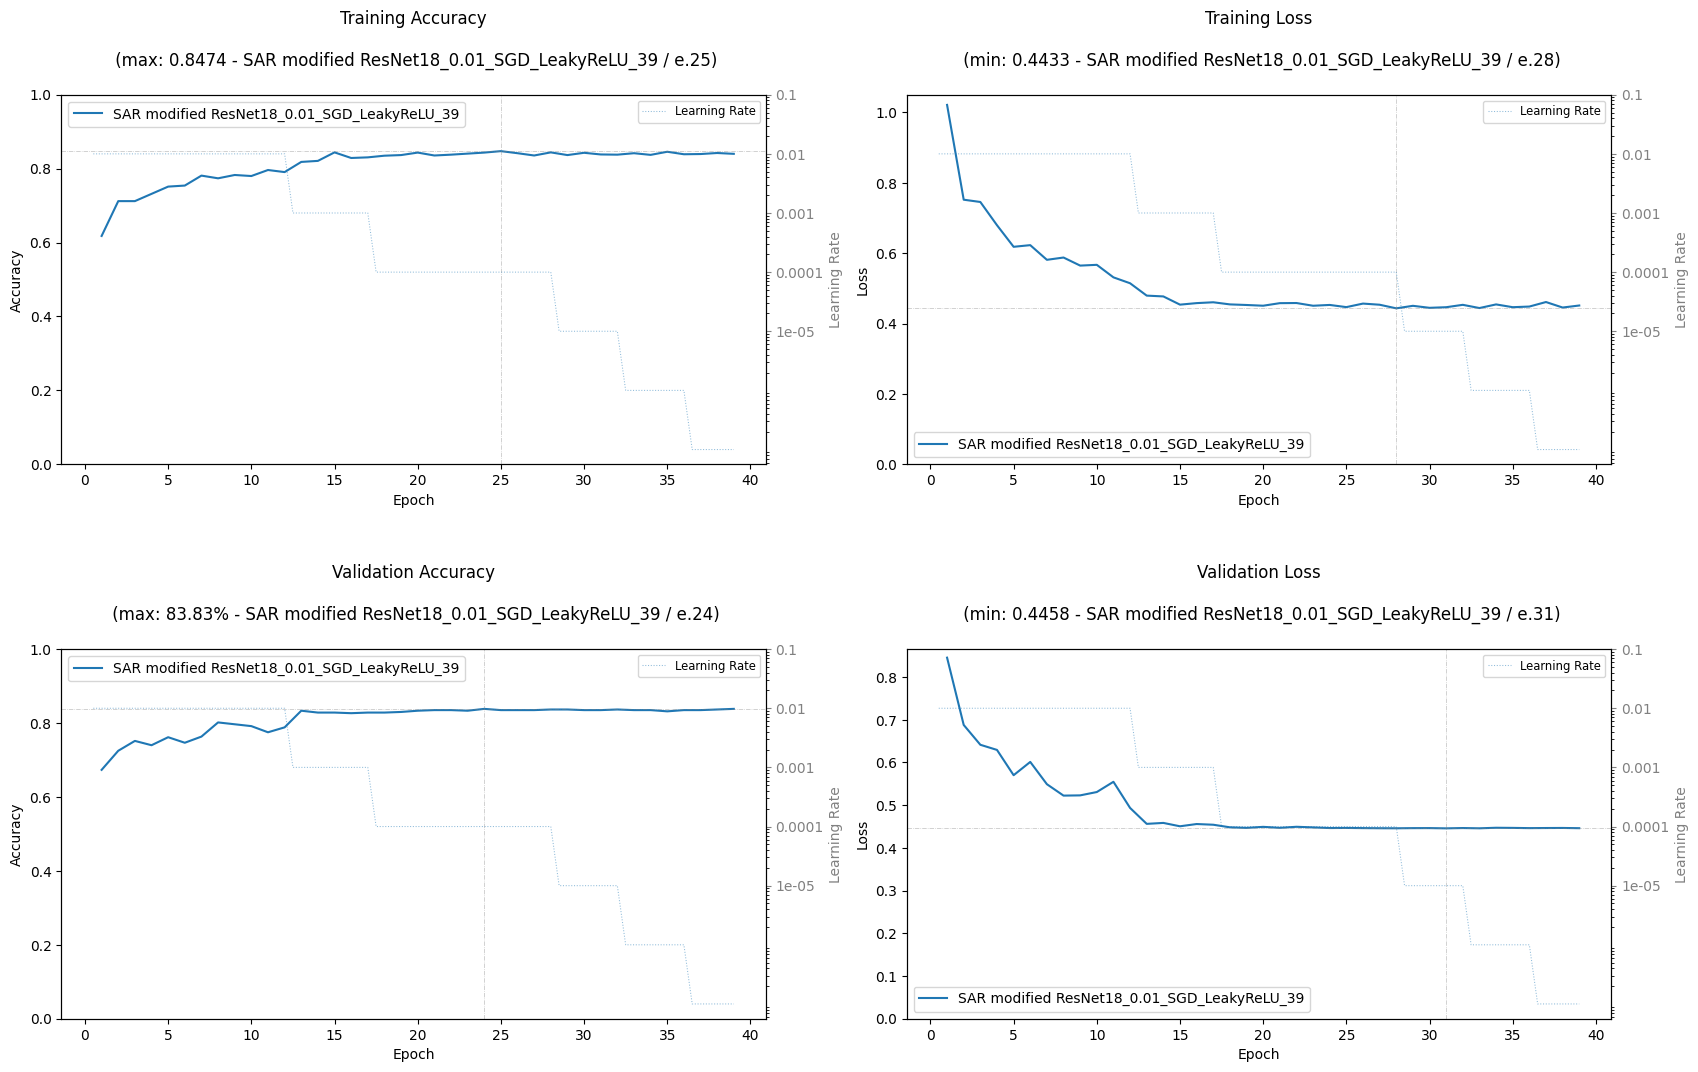

In [ ]:
plt.style.use('default')
plot_metrics()

In [ ]:
def evaluate_model(model_list, dataloaders, class_names, mount_point, project_folder, softmax_folder):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # List .pth files in the project folder
    project_path = os.path.join(mount_point, project_folder)
    pth_files = [f for f in os.listdir(project_path) if f.endswith('.pth')]

    # Print numbered list of .pth files
    print("Available models in a project folder:\n")
    for i, pth_file in enumerate(pth_files, start=1):
        print(f"{i}. {pth_file}")

    # Ask the user which file to process further
    selected_index = int(input("\nEnter the number corresponding to the file you want to process: ")) - 1
    selected_model_path = os.path.join(project_path, pth_files[selected_index])

    # Set the model to evaluation mode
    model_dict = model_list[0]  # Assuming there is only one model in the list, can be changed if needed

    model_name = model_dict["name"]
    model = model_dict["model"]
    model = model.to(device)
    model.eval()

    # Load the selected model weights
    if device.type == 'cuda':
        model.load_state_dict(torch.load(selected_model_path))
    else:
        model.load_state_dict(torch.load(selected_model_path, map_location=torch.device('cpu')))

    # Initialize GradCAM before entering the testing loop
    target_layer = model.resnet.layer4[-1]
    gradcam = GradCAM(model.resnet, target_layer)

    all_preds = []
    all_labels = []

    softmax_scores = []
    image_names = []

    test_progress_bar = tqdm(dataloaders['test'], desc='Testing progress')

    # Initialize empty lists to store length and width data
    length_data = []
    width_data = []

    # Initialize an empty list to store image features
    image_features = []

    # Initialize GradCAM before entering the testing loop
    #gradcam = GradCAM.from_config(model_type='resnet18', arch=model, layer_name='layer4')

    for inputs, labels, lengths, widths in test_progress_bar:
        if inputs is None or labels is None or lengths is None or widths is None:
            continue
            
        inputs = inputs.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)
        widths = widths.to(device)

        with torch.no_grad():
            outputs, features = model(inputs, lengths, widths)
            softmax = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)


        # Show original image
        plt.figure(figsize=(10, 10))
        plt.imshow(np.transpose(overlay, (1,2,0)))
        plt.title(f"Original Image - Predicted: {class_names[pred_label_idx]}, Confidence: {probas[0][pred_label_idx]:.2f}")
        plt.show()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        softmax_scores.append(softmax.cpu())


        # Add length and width data to the corresponding lists
        length_data.extend(lengths.cpu().numpy())
        width_data.extend(widths.cpu().numpy())

        # Add the output features of your model to the image features list
        image_features.extend(features.cpu().numpy())

        # Add visualization of the model's predictions
        if len(inputs) >= 16:
            # Make a grid from batch
            out = vutils.make_grid(inputs.cpu()[:16], nrow=4, normalize=True)
            plt.figure(figsize=(12,12))
            plt.imshow(np.transpose(out.numpy(), (1, 2, 0)))
            plt.title("Sample Test Images")
            plt.show()
            print("Predicted: ", [class_names[i] for i in preds.cpu()[:16].numpy()])

        # Update progress bar
        test_progress_bar.set_postfix(acc=torch.sum(preds == labels.data))

    # Convert lists to NumPy arrays
    length_data_np = np.array(length_data)
    width_data_np = np.array(width_data)
    image_features_np = np.array(image_features)

    print(image_features_np.shape)

    # Plot histograms
    plt.figure(figsize=(10, 5))
    plt.hist(image_features_np.ravel(), bins=100, alpha=0.5, label='Image Features')
    plt.xlabel('Feature Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.hist(length_data_np, bins=100, alpha=0.5, label='Length')
    plt.hist(width_data_np, bins=100, alpha=0.5, label='Width')
    plt.xlabel('Feature Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # Plot box plots
    plt.figure(figsize=(10, 5))
    plt.boxplot([image_features_np.ravel(), length_data_np, width_data_np], labels=['Image Features', 'Length', 'Width'])
    plt.ylabel('Feature Value')
    plt.show()

    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Test accuracy: {accuracy * 100:.2f}%')

    # softmax_scores = torch.cat(softmax_scores)

    # Plotting confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, linewidths=0.5, linecolor='black', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print('Classification Report:\n')
    print(report)

    #print(softmax_scores)

    # Saving softmax scores
    softmax_scores_path = os.path.join(mount_point, project_folder, softmax_folder, 'softmax_scores.npy')

    if not os.path.exists(softmax_scores_path):
        np.save(softmax_scores_path, softmax_scores)
        print(f'\nSoftmax scores saved to {softmax_scores_path}')
    else:
        print(f'\nSoftmax scores already stored in {softmax_scores_path}')

#torch.cuda.empty_cache()

# Testing the best model

In [ ]:
evaluate_model(model_list, dataloaders, actual_class_names, mount_point, project_folder, softmax_folder)

In [ ]:
print(image_features_np.shape)

Available models in a project folder:

1. ResNet18_acc0.5792_lr0.01_SGD_LeakyReLU_epoch16.pth
2. ResNet18_acc0.6606_lr0.01_SGD_LeakyReLU_epoch3_20230412-1708.pth
3. _SAR modified ResNet18_acc0.6897_lr0.01_SGD_LeakyReLU_epoch2_20230413-1944.pth
4. _SAR modified ResNet18_acc0.7833_lr0.01_SGD_LeakyReLU_epoch4_20230413-1952.pth
5. _SAR modified ResNet18_acc0.7668_lr0.01_SGD_LeakyReLU_epoch4_20230413-2015.pth
6. _SAR modified ResNet18_acc0.8670_lr0.01_SGD_LeakyReLU_epoch17_20230413-2027.pth
7. _SAR modified ResNet18_acc0.8339_lr0.01_SGD_LeakyReLU_w_layers_freeze_epoch14_20230517-1437.pth
8. _SAR modified ResNet18_acc0.7027_lr0.01_SGD_LeakyReLU_epoch4_20230517-1534.pth
9. _SAR modified ResNet18_acc0.8256_lr0.01_SGD_LeakyReLU_epoch8_20230517-1611.pth
10. _SAR modified ResNet18_acc0.8305_lr0.01_SGD_LeakyReLU_epoch32_20230517-1825.pth
11. _SAR modified ResNet18_acc0.9036_lr0.01_SGD_LeakyReLU_epoch25_20230518-0851.pth
12. _SAR modified ResNet18_acc0.8451_lr0.01_SGD_LeakyReLU_epoch9_20230518-0907

Testing progress:   0%|          | 0/10 [00:00<?, ?it/s]

Test accuracy: 83.42%


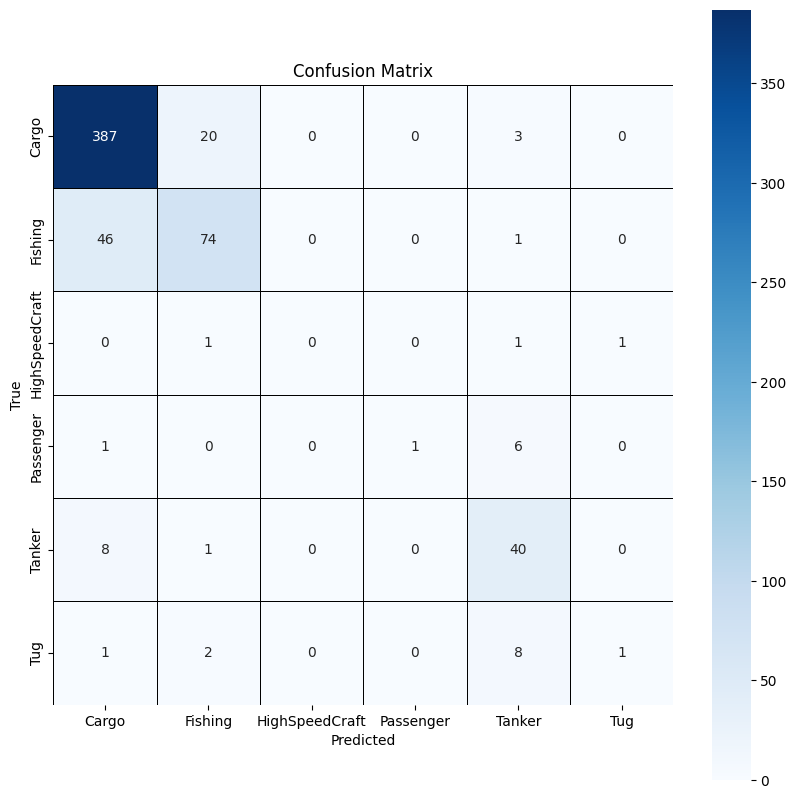

Classification Report:

                precision    recall  f1-score   support

         Cargo       0.87      0.94      0.91       410
       Fishing       0.76      0.61      0.68       121
HighSpeedCraft       0.00      0.00      0.00         3
     Passenger       1.00      0.12      0.22         8
        Tanker       0.68      0.82      0.74        49
           Tug       0.50      0.08      0.14        12

      accuracy                           0.83       603
     macro avg       0.63      0.43      0.45       603
  weighted avg       0.82      0.83      0.82       603


Softmax scores already stored in /content/drive/MyDrive/D7047E/PROJECT/softmax/softmax_scores.npy


In [ ]:
evaluate_model(model_list, dataloaders, actual_class_names, mount_point, project_folder, softmax_folder)

Available models in a project folder:

1. ResNet18_acc0.5792_lr0.01_SGD_LeakyReLU_epoch16.pth
2. ResNet18_acc0.6606_lr0.01_SGD_LeakyReLU_epoch3_20230412-1708.pth
3. _SAR modified ResNet18_acc0.6897_lr0.01_SGD_LeakyReLU_epoch2_20230413-1944.pth
4. _SAR modified ResNet18_acc0.7833_lr0.01_SGD_LeakyReLU_epoch4_20230413-1952.pth
5. _SAR modified ResNet18_acc0.7668_lr0.01_SGD_LeakyReLU_epoch4_20230413-2015.pth
6. _SAR modified ResNet18_acc0.8670_lr0.01_SGD_LeakyReLU_epoch17_20230413-2027.pth
7. _SAR modified ResNet18_acc0.8339_lr0.01_SGD_LeakyReLU_w_layers_freeze_epoch14_20230517-1437.pth
8. _SAR modified ResNet18_acc0.7027_lr0.01_SGD_LeakyReLU_epoch4_20230517-1534.pth
9. _SAR modified ResNet18_acc0.8256_lr0.01_SGD_LeakyReLU_epoch8_20230517-1611.pth
10. _SAR modified ResNet18_acc0.8305_lr0.01_SGD_LeakyReLU_epoch32_20230517-1825.pth
11. _SAR modified ResNet18_acc0.9036_lr0.01_SGD_LeakyReLU_epoch25_20230518-0851.pth
12. _SAR modified ResNet18_acc0.8451_lr0.01_SGD_LeakyReLU_epoch9_20230518-0907

Testing progress:   0%|          | 0/10 [00:00<?, ?it/s]

Test accuracy: 84.98%


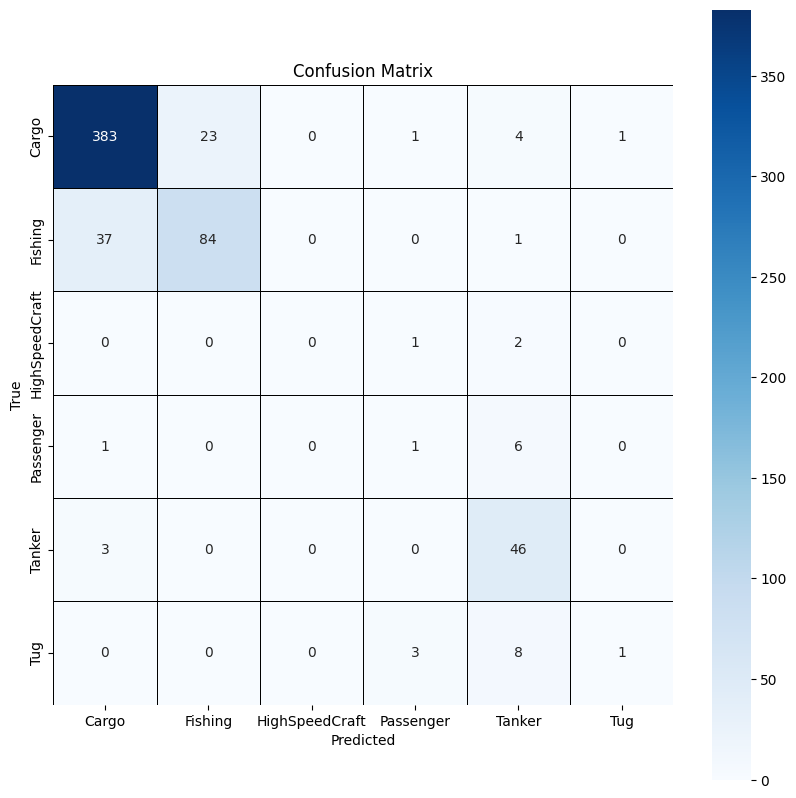

Classification Report:

                precision    recall  f1-score   support

         Cargo       0.90      0.93      0.92       412
       Fishing       0.79      0.69      0.73       122
HighSpeedCraft       0.00      0.00      0.00         3
     Passenger       0.17      0.12      0.14         8
        Tanker       0.69      0.94      0.79        49
           Tug       0.50      0.08      0.14        12

      accuracy                           0.85       606
     macro avg       0.51      0.46      0.45       606
  weighted avg       0.84      0.85      0.84       606


Softmax scores already stored in /content/drive/MyDrive/D7047E/PROJECT/softmax/softmax_scores.npy


In [ ]:
evaluate_model(model_list, dataloaders, actual_class_names, mount_point, project_folder, softmax_folder)

Available models in a project folder:

1. ResNet18_acc0.5792_lr0.01_SGD_LeakyReLU_epoch16.pth
2. ResNet18_acc0.6606_lr0.01_SGD_LeakyReLU_epoch3_20230412-1708.pth
3. _SAR modified ResNet18_acc0.6897_lr0.01_SGD_LeakyReLU_epoch2_20230413-1944.pth
4. _SAR modified ResNet18_acc0.7833_lr0.01_SGD_LeakyReLU_epoch4_20230413-1952.pth
5. _SAR modified ResNet18_acc0.7668_lr0.01_SGD_LeakyReLU_epoch4_20230413-2015.pth
6. _SAR modified ResNet18_acc0.8670_lr0.01_SGD_LeakyReLU_epoch17_20230413-2027.pth
7. _SAR modified ResNet18_acc0.8339_lr0.01_SGD_LeakyReLU_w_layers_freeze_epoch14_20230517-1437.pth
8. _SAR modified ResNet18_acc0.7027_lr0.01_SGD_LeakyReLU_epoch4_20230517-1534.pth
9. _SAR modified ResNet18_acc0.8256_lr0.01_SGD_LeakyReLU_epoch8_20230517-1611.pth
10. _SAR modified ResNet18_acc0.8305_lr0.01_SGD_LeakyReLU_epoch32_20230517-1825.pth
11. _SAR modified ResNet18_acc0.9036_lr0.01_SGD_LeakyReLU_epoch25_20230518-0851.pth
12. _SAR modified ResNet18_acc0.8451_lr0.01_SGD_LeakyReLU_epoch9_20230518-0907

Testing progress:   0%|          | 0/10 [00:00<?, ?it/s]

Test accuracy: 81.27%


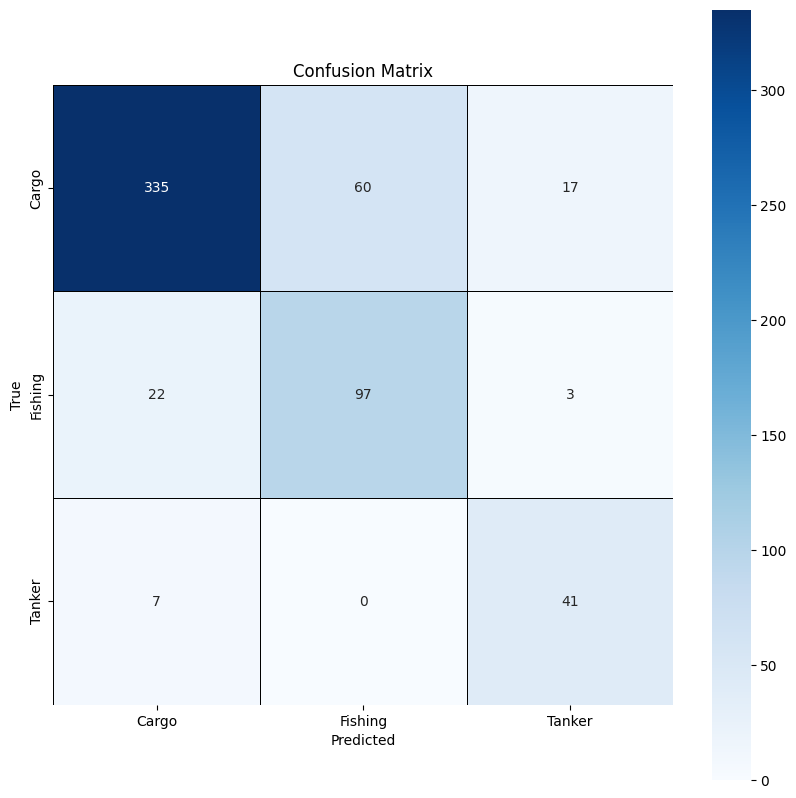

Classification Report:

              precision    recall  f1-score   support

       Cargo       0.92      0.81      0.86       412
     Fishing       0.62      0.80      0.70       122
      Tanker       0.67      0.85      0.75        48

    accuracy                           0.81       582
   macro avg       0.74      0.82      0.77       582
weighted avg       0.84      0.81      0.82       582


Softmax scores already stored in /content/drive/MyDrive/D7047E/PROJECT/softmax/softmax_scores.npy


In [ ]:
evaluate_model(model_list, dataloaders, actual_class_names, mount_point, project_folder, softmax_folder)

Available models in a project folder:

1. ResNet18_acc0.5792_lr0.01_SGD_LeakyReLU_epoch16.pth
2. ResNet18_acc0.6606_lr0.01_SGD_LeakyReLU_epoch3_20230412-1708.pth
3. _SAR modified ResNet18_acc0.6897_lr0.01_SGD_LeakyReLU_epoch2_20230413-1944.pth
4. _SAR modified ResNet18_acc0.7833_lr0.01_SGD_LeakyReLU_epoch4_20230413-1952.pth
5. _SAR modified ResNet18_acc0.7668_lr0.01_SGD_LeakyReLU_epoch4_20230413-2015.pth
6. _SAR modified ResNet18_acc0.8670_lr0.01_SGD_LeakyReLU_epoch17_20230413-2027.pth
7. _SAR modified ResNet18_acc0.8339_lr0.01_SGD_LeakyReLU_w_layers_freeze_epoch14_20230517-1437.pth
8. _SAR modified ResNet18_acc0.7027_lr0.01_SGD_LeakyReLU_epoch4_20230517-1534.pth
9. _SAR modified ResNet18_acc0.8256_lr0.01_SGD_LeakyReLU_epoch8_20230517-1611.pth
10. _SAR modified ResNet18_acc0.8305_lr0.01_SGD_LeakyReLU_epoch32_20230517-1825.pth

Enter the number corresponding to the file you want to process: 10


Testing progress:   0%|          | 0/10 [00:00<?, ?it/s]

Test accuracy: 82.29%


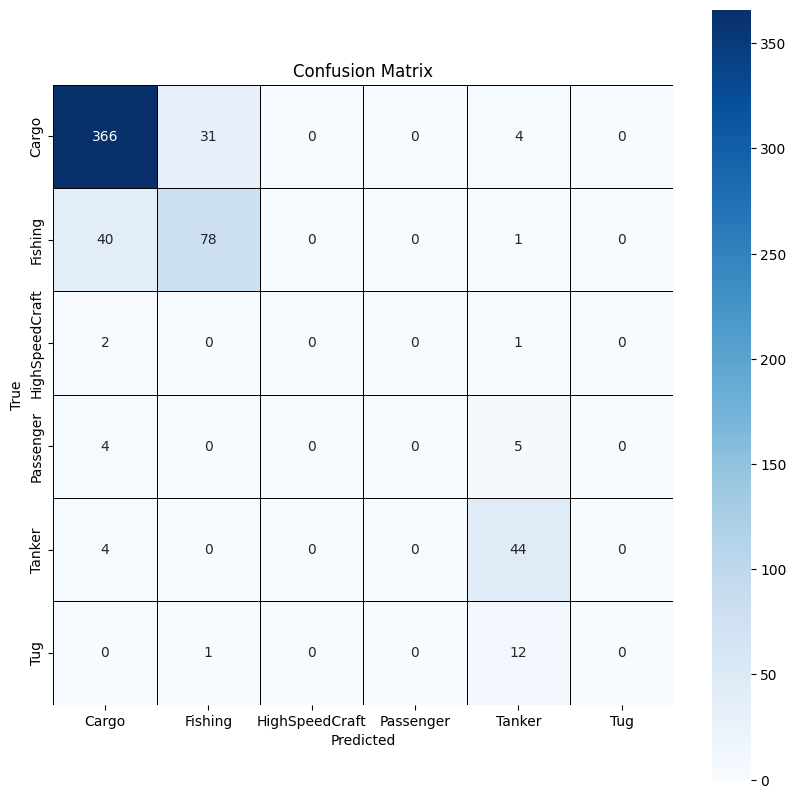

Classification Report:

                precision    recall  f1-score   support

         Cargo       0.88      0.91      0.90       401
       Fishing       0.71      0.66      0.68       119
HighSpeedCraft       0.00      0.00      0.00         3
     Passenger       0.00      0.00      0.00         9
        Tanker       0.66      0.92      0.77        48
           Tug       0.00      0.00      0.00        13

      accuracy                           0.82       593
     macro avg       0.37      0.41      0.39       593
  weighted avg       0.79      0.82      0.80       593


Softmax scores already stored in /content/drive/MyDrive/D7047E/PROJECT/softmax/softmax_scores.npy


In [ ]:
evaluate_model(model_list, dataloaders, actual_class_names, mount_point, project_folder, softmax_folder)

Available models in a project folder:

1. ResNet18_acc0.5792_lr0.01_SGD_LeakyReLU_epoch16.pth
2. ResNet18_acc0.6606_lr0.01_SGD_LeakyReLU_epoch3_20230412-1708.pth
3. _SAR modified ResNet18_acc0.6897_lr0.01_SGD_LeakyReLU_epoch2_20230413-1944.pth
4. _SAR modified ResNet18_acc0.7833_lr0.01_SGD_LeakyReLU_epoch4_20230413-1952.pth
5. _SAR modified ResNet18_acc0.7668_lr0.01_SGD_LeakyReLU_epoch4_20230413-2015.pth
6. _SAR modified ResNet18_acc0.8670_lr0.01_SGD_LeakyReLU_epoch17_20230413-2027.pth
7. _SAR modified ResNet18_acc0.8339_lr0.01_SGD_LeakyReLU_w_layers_freeze_epoch14_20230517-1437.pth
8. _SAR modified ResNet18_acc0.7027_lr0.01_SGD_LeakyReLU_epoch4_20230517-1534.pth
9. _SAR modified ResNet18_acc0.8256_lr0.01_SGD_LeakyReLU_epoch8_20230517-1611.pth

Enter the number corresponding to the file you want to process: 9


Testing progress:   0%|          | 0/10 [00:00<?, ?it/s]

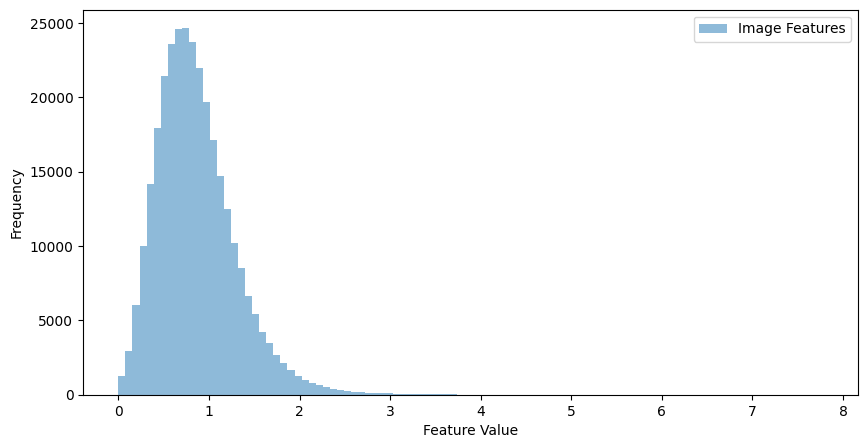

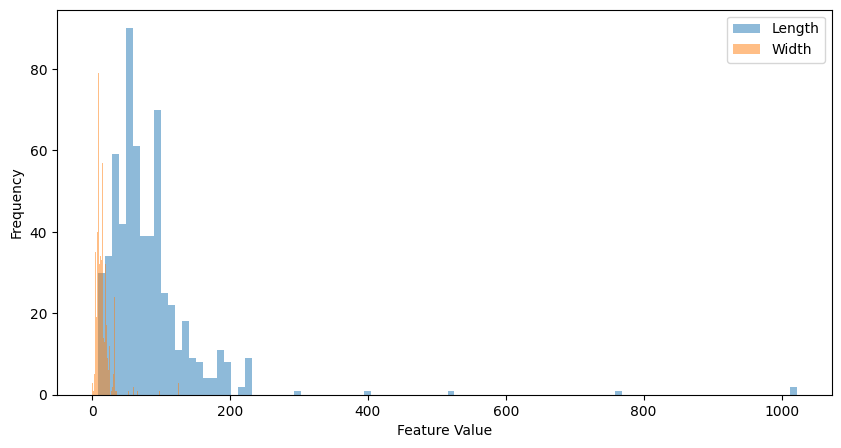

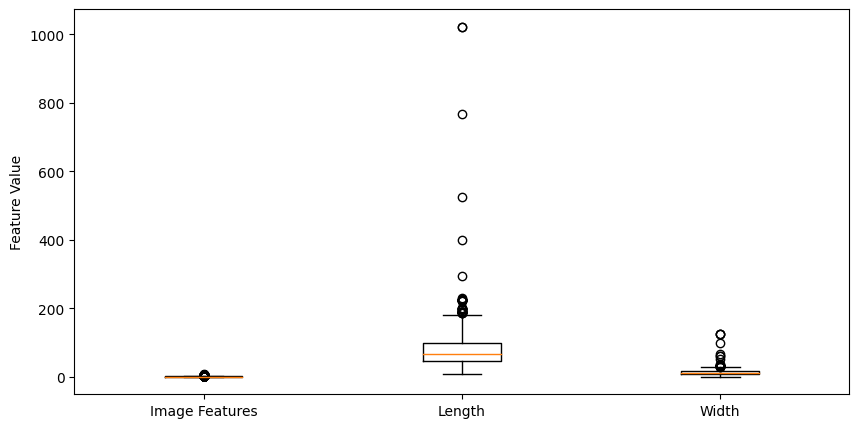

Test accuracy: 80.87%


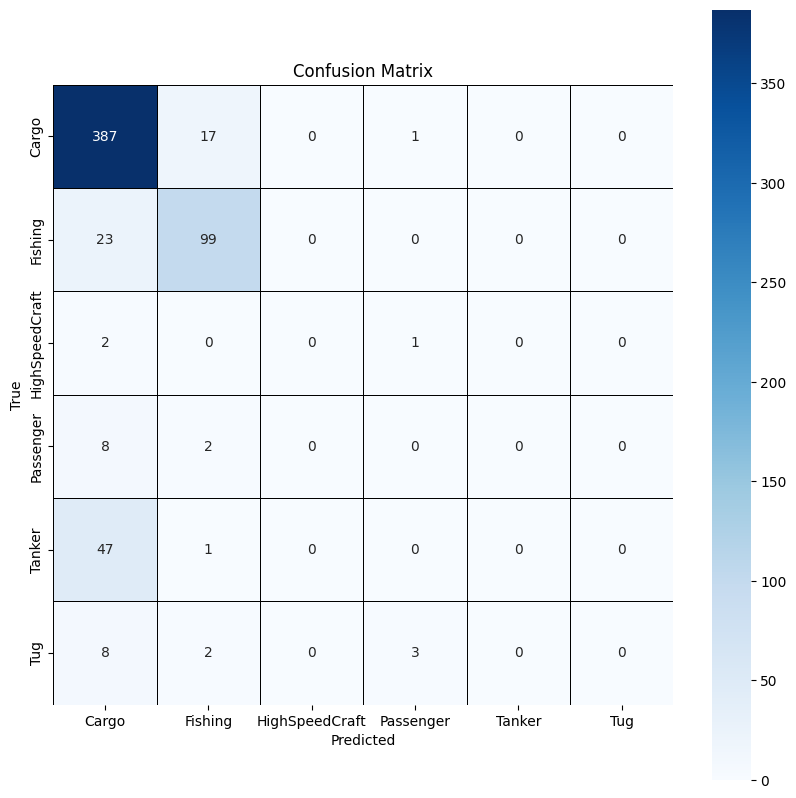

Classification Report:

                precision    recall  f1-score   support

         Cargo       0.81      0.96      0.88       405
       Fishing       0.82      0.81      0.81       122
HighSpeedCraft       0.00      0.00      0.00         3
     Passenger       0.00      0.00      0.00        10
        Tanker       0.00      0.00      0.00        48
           Tug       0.00      0.00      0.00        13

      accuracy                           0.81       601
     macro avg       0.27      0.29      0.28       601
  weighted avg       0.72      0.81      0.76       601


Softmax scores already stored in /content/drive/MyDrive/D7047E/PROJECT/softmax/softmax_scores.npy


In [ ]:
evaluate_model(model_list, dataloaders, actual_class_names, mount_point, project_folder, softmax_folder)

In [ ]:
print('Image features:')
print('Mean:', np.mean(image_features))
print('Median:', np.median(image_features))
print('Min:', np.min(image_features))
print('Max:', np.max(image_features))
print('Standard deviation:', np.std(image_features))

print('Length data:')
print('Mean:', np.mean(length_data))
print('Median:', np.median(length_data))
print('Min:', np.min(length_data))
print('Max:', np.max(length_data))
print('Standard deviation:', np.std(length_data))

print('Width data:')
print('Mean:', np.mean(width_data))
print('Median:', np.median(width_data))
print('Min:', np.min(width_data))
print('Max:', np.max(width_data))
print('Standard deviation:', np.std(width_data))

Image features:


NameError: ignored

Available models in a project folder:

1. ResNet18_acc0.5792_lr0.01_SGD_LeakyReLU_epoch16.pth
2. ResNet18_acc0.6606_lr0.01_SGD_LeakyReLU_epoch3_20230412-1708.pth
3. _SAR modified ResNet18_acc0.6897_lr0.01_SGD_LeakyReLU_epoch2_20230413-1944.pth
4. _SAR modified ResNet18_acc0.7833_lr0.01_SGD_LeakyReLU_epoch4_20230413-1952.pth
5. _SAR modified ResNet18_acc0.7668_lr0.01_SGD_LeakyReLU_epoch4_20230413-2015.pth
6. _SAR modified ResNet18_acc0.8670_lr0.01_SGD_LeakyReLU_epoch17_20230413-2027.pth
7. _SAR modified ResNet18_acc0.8339_lr0.01_SGD_LeakyReLU_w_layers_freeze_epoch14_20230517-1437.pth

Enter the number corresponding to the file you want to process: 7


Testing progress:   0%|          | 0/10 [00:00<?, ?it/s]

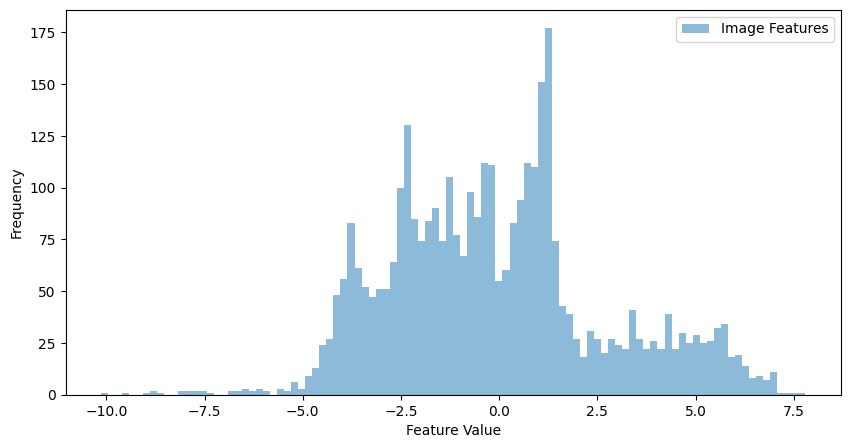

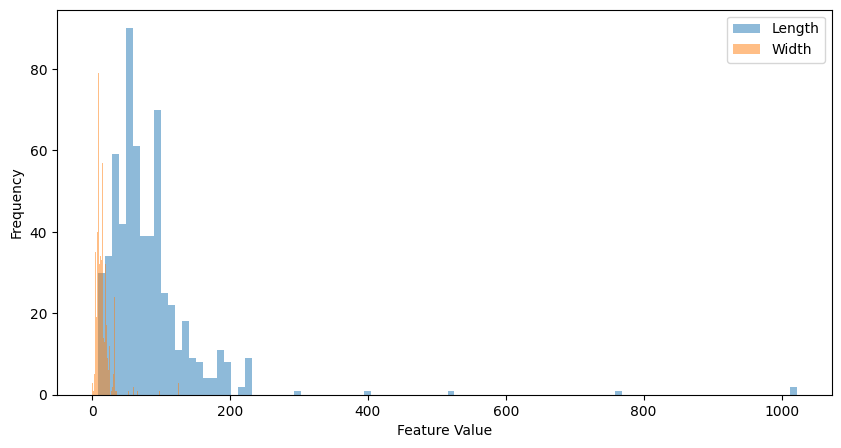

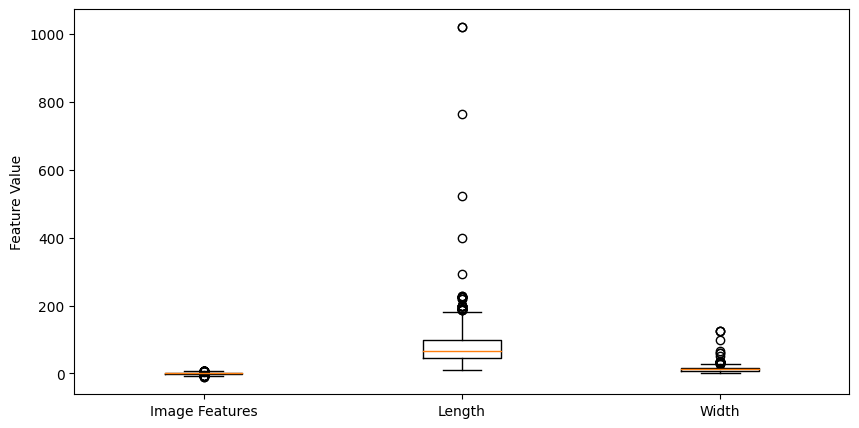

Test accuracy: 86.52%


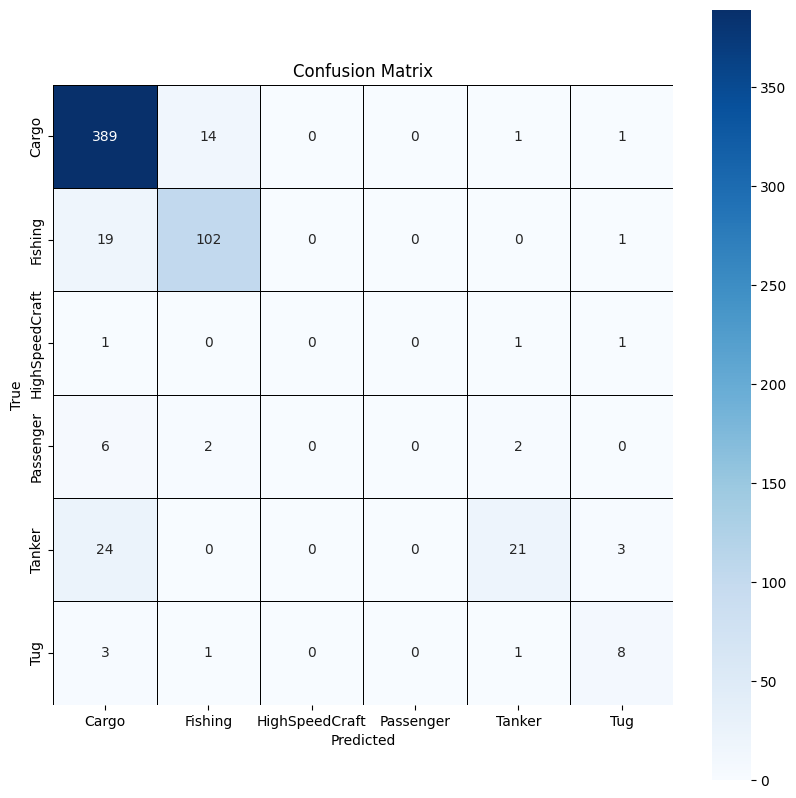

Classification Report:

                precision    recall  f1-score   support

         Cargo       0.88      0.96      0.92       405
       Fishing       0.86      0.84      0.85       122
HighSpeedCraft       0.00      0.00      0.00         3
     Passenger       0.00      0.00      0.00        10
        Tanker       0.81      0.44      0.57        48
           Tug       0.57      0.62      0.59        13

      accuracy                           0.87       601
     macro avg       0.52      0.47      0.49       601
  weighted avg       0.84      0.87      0.85       601


Softmax scores already stored in /content/drive/MyDrive/D7047E/PROJECT/softmax/softmax_scores.npy


In [ ]:
evaluate_model(model_list, dataloaders, actual_class_names, mount_point, project_folder, softmax_folder)

In [ ]:
unique_labels = set(labels)
print(unique_labels)
print(actual_class_names)

{1, 4, 5, 8, 12, 13}
['Cargo', 'Fishing', 'HighSpeedCraft', 'Passenger', 'Tanker', 'Tug']
